# Treść zadania
Przygotować raport dotyczący stanu opieki zdrowotnej w zakresie opieki geriatrycznej zawierający m.in. informacje o liczbie oddziałów oraz poradni geriatrycznych wraz z liczbą udzielonych świadczeń.
Proponowane źródła danych:

* https://basiw.mz.gov.pl/mapy-informacje/mapa-2022-2026/analizy/
* https://stat.gov.pl/
* https://bdl.stat.gov.pl/bdl/dane/podgrup/temat

Należy pobrać dane z odnalezionych źródeł a następnie załadować, wyczyścić oraz przygotować wizualizację w wybranych pakietach R lub Python.

Raport ma zawierać wizualizacje ogólnodostępnych danych wraz z ich opisem i zaobserwowanymi wnioskami. Warto skomentować zmiany w ostatnich latach.
Do raportu załączyć wykorzystany kod realizujący te zadania.

# Instalacja pakietów i import bibliotek

In [1]:
pip install geopandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install dash

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# import bibliotek

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
import base64
import os
import dash
import threading
from dash import Dash, dcc, html, callback, Input, Output

# Analiza pliku "swiad_woj"

In [4]:
# Ładuję plik dotyczący świadczeń wg.województw pobrany ze strony https://basiw.mz.gov.pl/mapy-informacje/mapa-2022-2026/analizy/ambulatoryjna-opieka-specjalistyczna/

df_aos = pd.read_csv(r"Input\swiad_woj.csv", encoding="utf-8")

In [5]:
df_aos.head()

,Rok,Województwo,Populacja,Specjalność komórki,Liczba porad AOS,Liczba porad AOS/1 tys. mieszk.,Liczba poradni AOS,Liczba poradni AOS/10 tys. mieszk.
0,2022,dolnośląskie,2888033,poradnia alergologiczna,157481,54.53,63,0.22
1,2022,dolnośląskie,2888033,poradnia alergologiczna dla dzieci,29324,10.15,11,0.04
2,2022,dolnośląskie,2888033,poradnia audiologiczna,8453,2.93,6,0.02
3,2022,dolnośląskie,2888033,poradnia chemioterapii,18280,6.33,3,0.01
4,2022,dolnośląskie,2888033,poradnia chirurgii klatki piersiowej,5268,1.82,2,0.01


In [6]:
df_aos.rename(columns={
                        "Województwo": "Wojewodztwo",
                        "Specjalność komórki": "Specjalnosc_Komorki",
                        "Liczba porad AOS": "Liczba_Porad_AOS",
                        "Liczba porad AOS/1 tys. mieszk.": "Liczba_Porad_AOS_Na_1tys_Mieszkancow",
                        "Liczba poradni AOS": "Liczba_Poradni_AOS",
                        "Liczba poradni AOS/10 tys. mieszk.": "Liczba_Poradni_AOS_Na_10tys_Mieszkancow"
                        }, inplace=True)

In [7]:
df_aos.head()

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow
0,2022,dolnośląskie,2888033,poradnia alergologiczna,157481,54.53,63,0.22
1,2022,dolnośląskie,2888033,poradnia alergologiczna dla dzieci,29324,10.15,11,0.04
2,2022,dolnośląskie,2888033,poradnia audiologiczna,8453,2.93,6,0.02
3,2022,dolnośląskie,2888033,poradnia chemioterapii,18280,6.33,3,0.01
4,2022,dolnośląskie,2888033,poradnia chirurgii klatki piersiowej,5268,1.82,2,0.01


In [8]:
# Filtruję po kolumnie "Specjalnosc_Komorki" wszystkie rekordy zawierające słowo "geriatr" bez względu na wielkość liter

df_aos_geriatria = df_aos[df_aos["Specjalnosc_Komorki"].str.contains("geriatr", case=False, na=False)]

In [9]:
df_aos_geriatria

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow
29,2022,dolnośląskie,2888033,poradnia geriatryczna,2502,0.87,4,0.01
115,2022,kujawsko-pomorskie,2006876,poradnia geriatryczna,5643,2.81,7,0.03
201,2022,lubelskie,2024637,poradnia geriatryczna,1597,0.79,5,0.02
280,2022,lubuskie,979976,poradnia geriatryczna,1316,1.34,3,0.03
360,2022,mazowieckie,5510612,poradnia geriatryczna,6717,1.22,10,0.02
...,...,...,...,...,...,...,...,...
8897,2016,wielkopolskie,3481625,poradnia geriatryczna,2375,0.68,7,0.02
8978,2016,zachodniopomorskie,1708174,poradnia geriatryczna,1905,1.12,3,0.02
9058,2016,łódzkie,2485323,poradnia geriatryczna,2778,1.12,5,0.02
9151,2016,śląskie,4559164,poradnia geriatryczna,16550,3.63,18,0.04


In [10]:
# Sprawdzam unikalne wartości po filtracji

df_aos_geriatria["Specjalnosc_Komorki"].unique()

array(['poradnia geriatryczna'], dtype=object)

In [11]:
df_aos_geriatria.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 29 to 9243
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rok                                      112 non-null    int64  
 1   Wojewodztwo                              112 non-null    object 
 2   Populacja                                112 non-null    int64  
 3   Specjalnosc_Komorki                      112 non-null    object 
 4   Liczba_Porad_AOS                         112 non-null    int64  
 5   Liczba_Porad_AOS_Na_1tys_Mieszkancow     112 non-null    float64
 6   Liczba_Poradni_AOS                       112 non-null    int64  
 7   Liczba_Poradni_AOS_Na_10tys_Mieszkancow  112 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.9+ KB


In [12]:
# Sprawdzam czy są jakieś duplikaty

df_aos_geriatria.duplicated().sum()

0

> Postanowiłam dodać dane z liczbą mieszkańców w wieku 60+ żeby orientacyjnie policzyć dostępność poradni i ilość porad na mieszkańca wskazanej grupy wiekowej

In [13]:
df_aos_geriatria["Wojewodztwo"].unique()

array(['dolnośląskie', 'kujawsko-pomorskie', 'lubelskie', 'lubuskie',
       'mazowieckie', 'małopolskie', 'opolskie', 'podkarpackie',
       'podlaskie', 'pomorskie', 'warmińsko-mazurskie', 'wielkopolskie',
       'zachodniopomorskie', 'łódzkie', 'śląskie', 'świętokrzyskie'],
      dtype=object)

In [14]:
# Ładuję plik dotyczący stanu ludności 60+ pobrany ze strony https://bdl.stat.gov.pl/bdl/dane/podgrup/tablica

df_ludnosc = pd.read_csv(r"Input\K3.G7.P2137 Ludność wg wieku i płci, 60+\LUDN_2137_CREL_20240707161221.csv", encoding="utf-8", sep=";")

In [15]:
df_ludnosc

,Kod,Nazwa,Wiek,Płeć,Rok,Wartosc,Jednostka miary,Atrybut,Unnamed: 8
0,200000,DOLNOŚLĄSKIE,60-64,mężczyźni,2016,106924,osoba,NaN,NaN
1,200000,DOLNOŚLĄSKIE,60-64,mężczyźni,2017,106532,osoba,NaN,NaN
2,200000,DOLNOŚLĄSKIE,60-64,mężczyźni,2018,105854,osoba,NaN,NaN
3,200000,DOLNOŚLĄSKIE,60-64,mężczyźni,2019,104203,osoba,NaN,NaN
4,200000,DOLNOŚLĄSKIE,60-64,mężczyźni,2020,98545,osoba,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1787,3200000,ZACHODNIOPOMORSKIE,85 i więcej,kobiety,2019,24473,osoba,NaN,NaN
1788,3200000,ZACHODNIOPOMORSKIE,85 i więcej,kobiety,2020,24497,osoba,NaN,NaN
1789,3200000,ZACHODNIOPOMORSKIE,85 i więcej,kobiety,2021,24426,osoba,NaN,NaN
1790,3200000,ZACHODNIOPOMORSKIE,85 i więcej,kobiety,2022,24552,osoba,NaN,NaN


In [16]:
df_ludnosc.rename(columns={
                            "Nazwa": "Wojewodztwo",
                            "Płeć": "Plec",
                            "Wartosc": "Liczba_ludnosci",
                        }, inplace=True)

In [17]:
df_ludnosc = df_ludnosc[["Rok", "Wojewodztwo", "Wiek", "Plec", "Liczba_ludnosci"]]
df_ludnosc["Wojewodztwo"] = df_ludnosc["Wojewodztwo"].str.lower()
df_ludnosc.head()

C:\Users\ktkat\AppData\Local\Temp\ipykernel_21128\3091342860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ludnosc["Wojewodztwo"] = df_ludnosc["Wojewodztwo"].str.lower()


,Rok,Wojewodztwo,Wiek,Plec,Liczba_ludnosci
0,2016,dolnośląskie,60-64,mężczyźni,106924
1,2017,dolnośląskie,60-64,mężczyźni,106532
2,2018,dolnośląskie,60-64,mężczyźni,105854
3,2019,dolnośląskie,60-64,mężczyźni,104203
4,2020,dolnośląskie,60-64,mężczyźni,98545


In [18]:
df_ludnosc_by_year = df_ludnosc.groupby("Rok")[["Liczba_ludnosci"]].sum()
df_ludnosc_by_year

,Liczba_ludnosci
Rok,
2016,13085730
2017,13459869
2018,13827817
2019,14188327
2020,14273639
2021,14410243
2022,14637611
2023,14924025


In [19]:
df_aos_geriatria.groupby("Rok")[["Populacja"]].sum()

,Populacja
Rok,
2016,38432992
2017,38433558
2018,38411148
2019,38382576
2020,38265013
2021,38080411
2022,37766327


In [20]:
df_ludnosc_by_year_and_region = df_ludnosc.groupby(["Rok", "Wojewodztwo"])[["Liczba_ludnosci"]].sum()
df_ludnosc_by_year_and_region.reset_index(inplace=True)
df_ludnosc_by_year_and_region

,Rok,Wojewodztwo,Liczba_ludnosci
0,2016,dolnośląskie,1023294
1,2016,kujawsko-pomorskie,688601
2,2016,lubelskie,748493
3,2016,lubuskie,328513
4,2016,mazowieckie,1868141
...,...,...,...
123,2023,wielkopolskie,1289946
124,2023,zachodniopomorskie,682258
125,2023,łódzkie,1037897
126,2023,śląskie,1824808


> Wracam do poprzedniej ramki danych, agreguję dane po roku i doklejam wartości z liczbą ludności 60+ a następnie liczę dostępność poradni i usług przypadających na osobę

In [21]:
df_aos_geriatria = pd.merge(df_aos_geriatria, df_ludnosc_by_year_and_region, on=["Rok", "Wojewodztwo"])
df_aos_geriatria

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow,Liczba_ludnosci
0,2022,dolnośląskie,2888033,poradnia geriatryczna,2502,0.87,4,0.01,1160198
1,2022,kujawsko-pomorskie,2006876,poradnia geriatryczna,5643,2.81,7,0.03,782687
2,2022,lubelskie,2024637,poradnia geriatryczna,1597,0.79,5,0.02,820663
3,2022,lubuskie,979976,poradnia geriatryczna,1316,1.34,3,0.03,381658
4,2022,mazowieckie,5510612,poradnia geriatryczna,6717,1.22,10,0.02,2039941
...,...,...,...,...,...,...,...,...,...
107,2016,wielkopolskie,3481625,poradnia geriatryczna,2375,0.68,7,0.02,1091203
108,2016,zachodniopomorskie,1708174,poradnia geriatryczna,1905,1.12,3,0.02,577279
109,2016,łódzkie,2485323,poradnia geriatryczna,2778,1.12,5,0.02,937618
110,2016,śląskie,4559164,poradnia geriatryczna,16550,3.63,18,0.04,1642612


In [22]:
df_aos_geriatria.rename(columns={"Liczba_ludnosci": "Liczba_ludnosci_60+"}, inplace=True)
df_aos_geriatria.drop(["Liczba_Porad_AOS_Na_1tys_Mieszkancow", "Liczba_Poradni_AOS_Na_10tys_Mieszkancow"], axis=1, inplace=True)

In [23]:
df_aos_geriatria["Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+"] = df_aos_geriatria["Liczba_Porad_AOS"] / (df_aos_geriatria["Liczba_ludnosci_60+"]/1000)
df_aos_geriatria["Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+"] = df_aos_geriatria["Liczba_Poradni_AOS"] / (df_aos_geriatria["Liczba_ludnosci_60+"]/10000)

In [24]:
df_aos_geriatria.head()

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Poradni_AOS,Liczba_ludnosci_60+,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+
0,2022,dolnośląskie,2888033,poradnia geriatryczna,2502,4,1160198,2.156528,0.034477
1,2022,kujawsko-pomorskie,2006876,poradnia geriatryczna,5643,7,782687,7.209779,0.089435
2,2022,lubelskie,2024637,poradnia geriatryczna,1597,5,820663,1.945988,0.060926
3,2022,lubuskie,979976,poradnia geriatryczna,1316,3,381658,3.448113,0.078604
4,2022,mazowieckie,5510612,poradnia geriatryczna,6717,10,2039941,3.292742,0.049021


In [25]:
# Agreguję dane -> sumuję liczbę porad i poradni, wyciągam średnią z liczby porad na 1 tyś. mieszkańców i liczby poradni na 10 tyś. mieszkańców

df_aos_geriatria_grouped_by_year = df_aos_geriatria.groupby("Rok").agg({"Liczba_ludnosci_60+" : "sum", "Liczba_Porad_AOS": "sum", "Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+": "mean", "Liczba_Poradni_AOS": "sum", "Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+": "mean"})

In [26]:
df_aos_geriatria_grouped_by_year

,Liczba_ludnosci_60+,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+
Rok,,,,,
2016,13085730,68584,4.833370,82,0.058632
2017,13459869,65661,4.482607,80,0.056092
2018,13827817,66076,4.467675,90,0.062536
2019,14188327,69696,4.676043,94,0.065433
2020,14273639,53971,3.655873,97,0.067156
2021,14410243,62211,4.316073,94,0.064671
2022,14637611,67382,4.728778,101,0.069830


In [27]:
# Doliczam roczny wzrost/spadek % 

df_aos_geriatria_grouped_by_year["L_Porad_Zmiana"] = df_aos_geriatria_grouped_by_year["Liczba_Porad_AOS"].pct_change() * 100
df_aos_geriatria_grouped_by_year["L_Poradni_Zmiana"] = df_aos_geriatria_grouped_by_year["Liczba_Poradni_AOS"].pct_change() * 100
df_aos_geriatria_grouped_by_year["L_Porad_Na_1tys_M_Zmiana"] = df_aos_geriatria_grouped_by_year["Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+"].pct_change() * 100
df_aos_geriatria_grouped_by_year["L_Poradni_Na_10tys_M_Zmiana"] = df_aos_geriatria_grouped_by_year["Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+"].pct_change() * 100

In [28]:
df_aos_geriatria_grouped_by_year

,Liczba_ludnosci_60+,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+,L_Porad_Zmiana,L_Poradni_Zmiana,L_Porad_Na_1tys_M_Zmiana,L_Poradni_Na_10tys_M_Zmiana
Rok,,,,,,,,,
2016,13085730,68584,4.833370,82,0.058632,NaN,NaN,NaN,NaN
2017,13459869,65661,4.482607,80,0.056092,-4.261927,-2.439024,-7.257117,-4.332309
2018,13827817,66076,4.467675,90,0.062536,0.632034,12.500000,-0.333100,11.489640
2019,14188327,69696,4.676043,94,0.065433,5.478540,4.444444,4.663909,4.631951
2020,14273639,53971,3.655873,97,0.067156,-22.562270,3.191489,-21.816952,2.633324
2021,14410243,62211,4.316073,94,0.064671,15.267458,-3.092784,18.058602,-3.701006
2022,14637611,67382,4.728778,101,0.069830,8.312035,7.446809,9.562055,7.978560


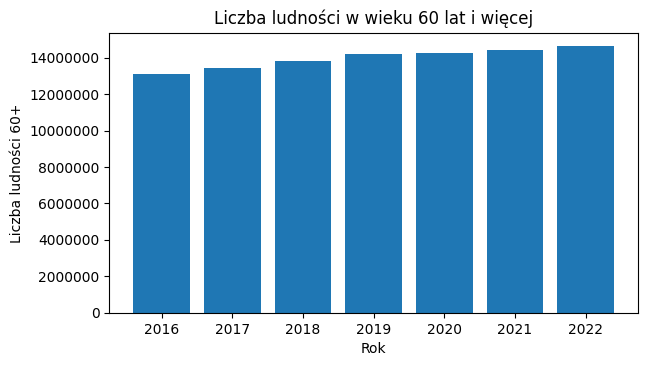

In [29]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.bar(df_aos_geriatria_grouped_by_year.index, df_aos_geriatria_grouped_by_year["Liczba_ludnosci_60+"])
plt.title("Liczba ludności w wieku 60 lat i więcej")
plt.xlabel("Rok")
plt.ylabel("Liczba ludności 60+")
plt.grid(False)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.show()

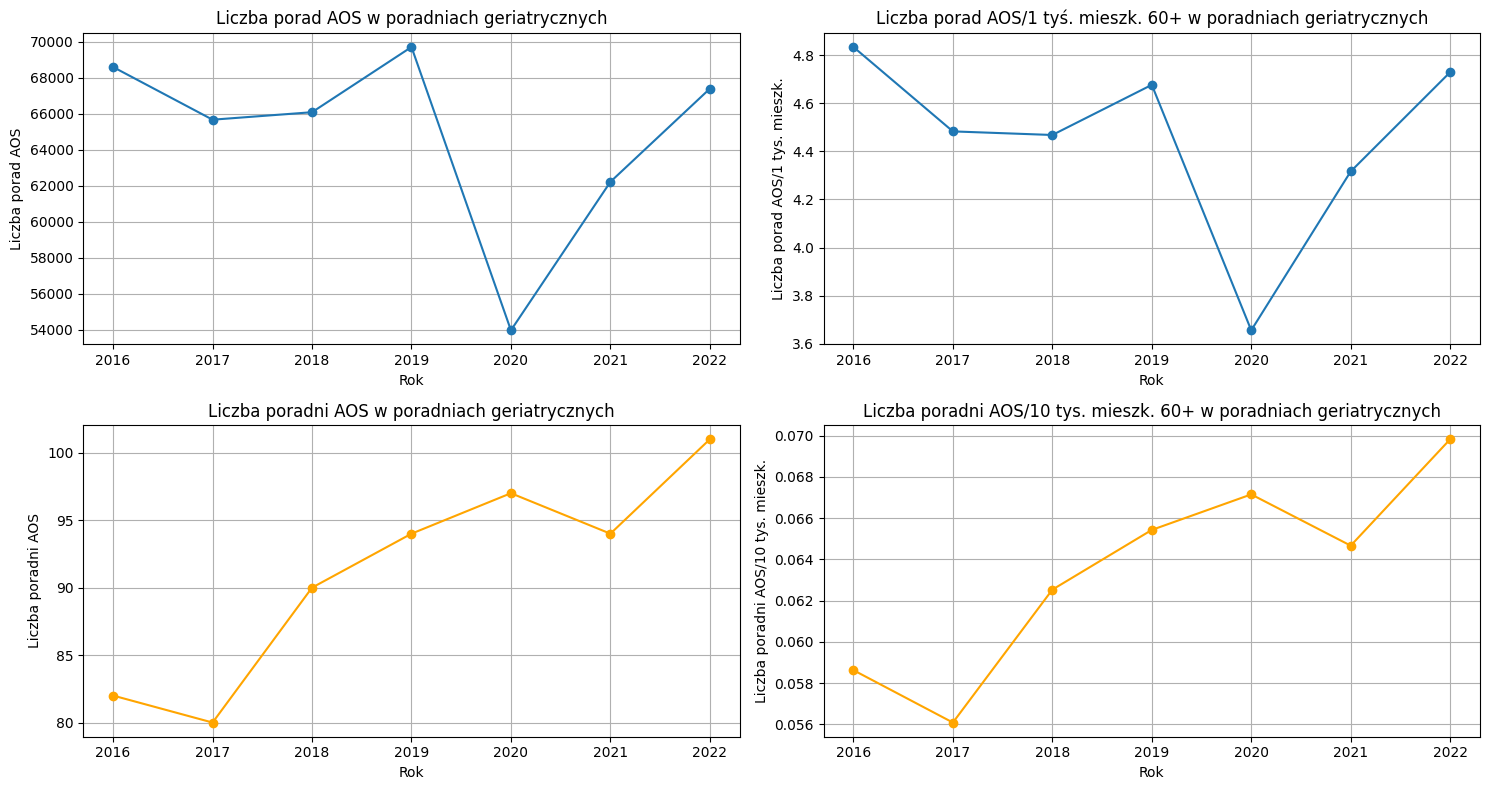

In [30]:
# Szybkie wykresy w matplotlib

# Wykres liczby porad AOS w poradniach geriatrycznych w poszczególnych latach
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.plot(df_aos_geriatria_grouped_by_year.index, df_aos_geriatria_grouped_by_year["Liczba_Porad_AOS"], marker="o")
plt.title("Liczba porad AOS w poradniach geriatrycznych")
plt.xlabel("Rok")
plt.ylabel("Liczba porad AOS")
plt.grid(True)

# Wykres liczby porad AOS/1 tyś. mieszk. w poradniach geriatrycznych w poszczególnych latach
plt.subplot(2,2,2)
plt.plot(df_aos_geriatria_grouped_by_year.index, df_aos_geriatria_grouped_by_year["Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+"], marker="o")
plt.title("Liczba porad AOS/1 tyś. mieszk. 60+ w poradniach geriatrycznych")
plt.xlabel("Rok")
plt.ylabel("Liczba porad AOS/1 tys. mieszk.")
plt.grid(True)

# Wykres liczby poradni geriatrycznych AOS w poszczególnych latach
plt.subplot(2,2,3)
plt.plot(df_aos_geriatria_grouped_by_year.index, df_aos_geriatria_grouped_by_year["Liczba_Poradni_AOS"], marker="o", color="orange")
plt.title("Liczba poradni AOS w poradniach geriatrycznych")
plt.xlabel("Rok")
plt.ylabel("Liczba poradni AOS")
plt.grid(True)

# Wykres liczby poradni geriatrycznych AOS w poszczególnych latach
plt.subplot(2,2,4)
plt.plot(df_aos_geriatria_grouped_by_year.index, df_aos_geriatria_grouped_by_year["Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+"], marker="o", color="orange")
plt.title("Liczba poradni AOS/10 tys. mieszk. 60+ w poradniach geriatrycznych")
plt.xlabel("Rok")
plt.ylabel("Liczba poradni AOS/10 tys. mieszk.")
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
df_aos_geriatria_grouped_by_year.reset_index(inplace=True)
df_aos_geriatria_grouped_by_year

,Rok,Liczba_ludnosci_60+,Liczba_Porad_AOS,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+,L_Porad_Zmiana,L_Poradni_Zmiana,L_Porad_Na_1tys_M_Zmiana,L_Poradni_Na_10tys_M_Zmiana
0,2016,13085730,68584,4.833370,82,0.058632,NaN,NaN,NaN,NaN
1,2017,13459869,65661,4.482607,80,0.056092,-4.261927,-2.439024,-7.257117,-4.332309
2,2018,13827817,66076,4.467675,90,0.062536,0.632034,12.500000,-0.333100,11.489640
3,2019,14188327,69696,4.676043,94,0.065433,5.478540,4.444444,4.663909,4.631951
4,2020,14273639,53971,3.655873,97,0.067156,-22.562270,3.191489,-21.816952,2.633324
5,2021,14410243,62211,4.316073,94,0.064671,15.267458,-3.092784,18.058602,-3.701006
6,2022,14637611,67382,4.728778,101,0.069830,8.312035,7.446809,9.562055,7.978560


# Analiza liczby poradni geriatrycznych w ramach AOS

In [32]:
# Wykres słupkowy liczby poradni geriatrycznych AOS w poszczególnych latach

fig_l_poradni_bar = px.bar(
                                df_aos_geriatria_grouped_by_year, 
                                x="Rok", 
                                y="Liczba_Poradni_AOS", 
                                title="<b>Liczba poradni geriatrycznych AOS w poszczególnych latach",
                                labels={"Rok": "<b>Rok", "Liczba_Poradni_AOS": "<b>Liczba poradni geriatrycznych"},
                                height=500, 
                                width=1000,
                                color="Liczba_Poradni_AOS",
                            )

fig_l_poradni_bar.update_traces(
                                marker=dict(
                                            color="#D8A900",
                                            line=dict(color="#DFB419", width=0.7)
                                            ),
                                width=0.5,
                                hovertemplate="Rok: <b>%{x}</b> <br>Liczba poradni geriatrycznych: <b>%{y}</b>",
                                texttemplate="%{y}",
                                textposition="outside"
                            )

fig_l_poradni_bar.update_layout(
                                yaxis=dict(
                                            tickformat=",",
                                            showgrid=True,
                                            gridcolor="lightgray"
                                            ),
                                hoverlabel=dict(bgcolor="#F0D77F"),
                                hoverlabel_align="left",
                                plot_bgcolor="white",
                                paper_bgcolor="white",
                                xaxis=dict(
                                            showgrid=False,
                                            gridcolor="lightgray"
                                            )
                            )

fig_l_poradni_bar.show()


In [33]:
# Wykres liczby poradni geriatrycznych AOS/10 tyś. mieszkańców 60+ w poszczególnych latach

fig_l_poradni_line = px.line(  
                                    df_aos_geriatria_grouped_by_year, 
                                    x="Rok", 
                                    y="Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+", 
                                    markers=True,
                                    title="<b>Liczba poradni geriatrycznych AOS/10 tyś. mieszkańców 60+ w poszczególnych latach",
                                    labels={"Rok": "<b>Rok", "Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+": "<b>Liczba poradni/10 tyś. mieszkańców 60+"},
                                    height=500, 
                                    width=1000,
                                    )

fig_l_poradni_line.update_traces(
                                    line=dict(color="#DFB419"), 
                                    line_width=3, 
                                    marker=dict(color="#D8A900"), 
                                    marker_line_width=0.7, 
                                    marker_line_color = "#304C89",
                                    hovertemplate="Rok: <b>%{x}</b> <br>Liczba poradni/10 tyś. mieszkańców 60+: <b>%{y:.3f}</b>" 
                                    ) 
fig_l_poradni_line.update_layout(
                                    yaxis=dict( 
                                                tickformat=".3f",
                                                showgrid=True,
                                                gridcolor="lightgray"
                                                ),
                                    hoverlabel=dict(bgcolor="#F0D77F"),
                                    hoverlabel_align = "left",
                                    plot_bgcolor="white",
                                    paper_bgcolor="white",
                                    xaxis=dict(
                                                showgrid=True,
                                                gridcolor="lightgray"
                                                )
                                    )
fig_l_poradni_line.show()

In [34]:
# Wykres zmiany liczby poradni AOS w poszczególnych latach

fig_l_poradni_zmiana = px.bar(
                                    df_aos_geriatria_grouped_by_year, 
                                    x="Rok", 
                                    y="L_Poradni_Zmiana", 
                                    title="<b>Zmiana liczby poradni geriatrycznych w poszczególnych latach w stosunku do roku poprzedniego",
                                    labels={"Rok": "<b>Rok", "L_Poradni_Zmiana": "<b>Zmiana liczby poradni geriatrycznych (%)"},
                                    height=500, 
                                    width=1000,
                                    color="L_Poradni_Zmiana",
                                    color_continuous_scale=["#FF1A4F", "#D8A900", "#06D6A0"],
                                    color_continuous_midpoint=0
                                    )

fig_l_poradni_zmiana.update_traces(
                                    width=0.5,
                                    hovertemplate="Rok: <b>%{x}</b> <br>Zmiana liczby poradni geriatrycznych AOS: <b>%{y:.2f}</b>%",
                                    texttemplate="%{y:.2f}%",
                                    textposition="outside"
                                    )

fig_l_poradni_zmiana.update_layout(
                                    yaxis=dict(
                                                tickformat=".1f%",
                                                showgrid=True,
                                                gridcolor="lightgray",
                                                zeroline=True,
                                                zerolinecolor="gray",
                                                zerolinewidth=1
                                                ),
                                    hoverlabel=dict(bgcolor="#B1CAF2"),
                                    hoverlabel_align="left",
                                    plot_bgcolor="white",
                                    paper_bgcolor="white",
                                    )

fig_l_poradni_zmiana.show()

# Analiza liczby porad AOS w poradniach geriatrycznych

In [35]:
# Wykres słupkowy liczby porad AOS w poradniach geriatrycznych w poszczególnych latach

fig_l_porad_bar = px.bar(
                                df_aos_geriatria_grouped_by_year, 
                                x="Rok", 
                                y="Liczba_Porad_AOS", 
                                title="<b>Liczba porad AOS w poradniach geriatrycznych w poszczególnych latach",
                                labels={"Rok": "<b>Rok", "Liczba_Porad_AOS": "<b>Liczba porad AOS"},
                                height=500, 
                                width=1000,
                                color="Liczba_Porad_AOS",
                            )

fig_l_porad_bar.update_traces(
                                marker=dict(
                                            color="#597AFF",
                                            line=dict(color="#304C89", width=0.7)
                                            ),
                                width=0.5,
                                hovertemplate="Rok: <b>%{x}</b> <br>Suma porad AOS: <b>%{y}</b>",
                                texttemplate="%{y}",
                                textposition="outside"
                            )

fig_l_porad_bar.update_layout(
                                yaxis=dict(
                                            tickformat=",",
                                            showgrid=True,
                                            gridcolor="lightgray"
                                            ),
                                hoverlabel=dict(bgcolor="#B1CAF2"),
                                hoverlabel_align="left",
                                plot_bgcolor="white",
                                paper_bgcolor="white",
                                xaxis=dict(
                                            showgrid=False,
                                            gridcolor="lightgray"
                                            )
                            )

fig_l_porad_bar.show()


In [36]:
# Wykres liczby porad AOS/1 tyś. mieszkańców 60+ w poradniach geriatrycznych w poszczególnych latach

fig_l_porad_line = px.line(     df_aos_geriatria_grouped_by_year, 
                                x="Rok", 
                                y="Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+", 
                                markers=True,
                                title="<b>Liczba porad AOS/1 tyś. mieszkańców 60+ w poradniach geriatrycznych w poszczególnych latach",
                                labels={"Rok": "<b>Rok", "Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+": "<b>Liczba porad AOS/1 tyś. mieszkańców 60+"},
                                height=500, 
                                width=1000,
                                )

fig_l_porad_line.update_traces( line=dict(color="#597AFF"), 
                                line_width=3, 
                                marker=dict(color="#B1CAF2"), 
                                marker_line_width=0.7, 
                                marker_line_color = "#304C89",
                                hovertemplate="Rok: <b>%{x}</b> <br>Średnia porad AOS/1 tyś. mieszkańców 60+: <b>%{y:.2f}</b>" 
                                ) 
fig_l_porad_line.update_layout(
                                yaxis=dict( 
                                            tickformat=",",
                                            showgrid=True,
                                            gridcolor="lightgray"
                                            ),
                                hoverlabel=dict(bgcolor="#B1CAF2"),
                                hoverlabel_align = "left",
                                plot_bgcolor="white",
                                paper_bgcolor="white",
                                xaxis=dict(
                                            showgrid=True,
                                            gridcolor="lightgray"
                                            )
                                )
fig_l_porad_line.show()

In [37]:
# # Wykres zmiany liczby porad AOS w poszczególnych latach

fig_l_porad_zmiana = px.bar(
                                    df_aos_geriatria_grouped_by_year, 
                                    x="Rok", 
                                    y="L_Porad_Zmiana", 
                                    title="<b>Zmiana liczby porad AOS w poszczególnych latach w stosunku do roku poprzedniego",
                                    labels={"Rok": "<b>Rok", "L_Porad_Zmiana": "<b>Zmiana liczby porad AOS (%)"},
                                    height=500, 
                                    width=1000,
                                    color="L_Porad_Zmiana",
                                    color_continuous_scale=["#FF1A4F", "#D8A900", "#06D6A0"],
                                    color_continuous_midpoint=0
                                )

fig_l_porad_zmiana.update_traces(
                                    width=0.5,
                                    hovertemplate="Rok: <b>%{x}</b> <br>Zmiana liczby porad AOS: <b>%{y:.2f}</b>%",
                                    texttemplate="%{y:.2f}%",
                                    textposition="outside"
                                )

fig_l_porad_zmiana.update_layout(
                                    yaxis=dict(
                                                tickformat=".1f%",
                                                showgrid=True,
                                                gridcolor="lightgray",
                                                zeroline=True,
                                                zerolinecolor="gray",
                                                zerolinewidth=1
                                                ),
                                    hoverlabel=dict(bgcolor="#B1CAF2"),
                                    hoverlabel_align="left",
                                    plot_bgcolor="white",
                                    paper_bgcolor="white",
                                )

fig_l_porad_zmiana.show()


In [38]:
# Porównanie zmiany liczby porad i zmiany liczby poradni AOS w poszczególnych latach

fig_porownanie = go.Figure()

fig_porownanie.add_trace(
                            go.Bar(
                                    x=df_aos_geriatria_grouped_by_year["Rok"],
                                    y=df_aos_geriatria_grouped_by_year["L_Porad_Zmiana"],
                                    name="Zmiana liczby porad AOS (%)",
                                    marker=dict(color="#597AFF"),
                                    hovertemplate="Rok: <b>%{x}</b> <br>Zmiana liczby porad AOS: <b>%{y:.2f}</b>%",
                                    texttemplate="%{y:.2f}%",
                                    textposition="outside",
                                    )
                        )

fig_porownanie.add_trace(
                            go.Bar(
                                    x=df_aos_geriatria_grouped_by_year["Rok"],
                                    y=df_aos_geriatria_grouped_by_year["L_Poradni_Zmiana"],
                                    name="Zmiana liczby poradni AOS (%)",
                                    marker=dict(color="#D8A900"),
                                    hovertemplate="Rok: <b>%{x}</b> <br>Zmiana liczby poradni geriatrycznych AOS: <b>%{y:.2f}</b>%",
                                    texttemplate="%{y:.2f}%",
                                    textposition="outside",
                                    )
                        )

fig_porownanie.update_layout(
                                barmode="group",
                                title="<b>Porównanie zmiany liczby porad AOS i liczby poradni AOS w poszczególnych latach",
                                xaxis=dict(title="<b>Rok"),
                                yaxis=dict(
                                                title="<b>Zmiana liczby porad AOS i liczby poradni AOS (%)", tickformat=".",
                                                showgrid=True,
                                                gridcolor="lightgray",
                                                zeroline=True,
                                                zerolinecolor="gray",
                                                zerolinewidth=1
                                                ),
                                plot_bgcolor="white",
                                paper_bgcolor="white",
                                yaxis_showgrid=True,
                                height=600, 
                                width=1200,
                                )

fig_porownanie.show()


In [39]:
fig_ludnosc = px.bar(
                            df_aos_geriatria_grouped_by_year,
                            x="Rok",
                            y=df_aos_geriatria_grouped_by_year["Liczba_ludnosci_60+"]/1000000,
                            title="<b>Liczba ludności w wieku 60 lat i więcej",
                            height=500,
                            width=800
                            )

fig_ludnosc.update_layout(
                            xaxis_title="<b>Rok",
                            yaxis_title="<b>Liczba ludności 60+ (mln)",
                            yaxis=dict(
                                        tickformat=",.1f",
                                        showgrid=False 
                                        ),
                            plot_bgcolor="white"
                            )

fig_ludnosc.update_traces(
                            width=0.7,
                            hovertemplate="Rok: <b>%{x}</b> <br>Liczba ludności 60+: <b>%{y:.1f}</b> mln",
                            texttemplate="%{y:.1f} mln",
                            textposition="outside"
                            )

fig_ludnosc.show()

# Analiza wg województw | MAPY

In [40]:
df_map = gpd.read_file(r"Input\wojewodztwa\wojewodztwa.shp")

In [41]:
df_aos_geriatria.tail()

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Poradni_AOS,Liczba_ludnosci_60+,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+
107,2016,wielkopolskie,3481625,poradnia geriatryczna,2375,7,1091203,2.176497,0.064149
108,2016,zachodniopomorskie,1708174,poradnia geriatryczna,1905,3,577279,3.299964,0.051968
109,2016,łódzkie,2485323,poradnia geriatryczna,2778,5,937618,2.962827,0.053327
110,2016,śląskie,4559164,poradnia geriatryczna,16550,18,1642612,10.075416,0.109582
111,2016,świętokrzyskie,1252900,poradnia geriatryczna,382,2,461789,0.827218,0.043310


In [42]:
df_map.rename(columns={"JPT_NAZWA_": "Wojewodztwo"}, inplace=True)

In [43]:
df_region_mapa_geriatria = df_aos_geriatria.merge(df_map[["Wojewodztwo", "geometry"]], on="Wojewodztwo")

In [44]:
df_region_mapa_geriatria_2016 = df_region_mapa_geriatria[df_region_mapa_geriatria["Rok"] == 2016]

In [45]:
gdf = gpd.GeoDataFrame(df_region_mapa_geriatria, geometry="geometry")

In [46]:
gdf.head()

,Rok,Wojewodztwo,Populacja,Specjalnosc_Komorki,Liczba_Porad_AOS,Liczba_Poradni_AOS,Liczba_ludnosci_60+,Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+,Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+,geometry
0,2022,dolnośląskie,2888033,poradnia geriatryczna,2502,4,1160198,2.156528,0.034477,"POLYGON ((351910.997 289041.305, 351818.002 28..."
1,2022,kujawsko-pomorskie,2006876,poradnia geriatryczna,5643,7,782687,7.209779,0.089435,"POLYGON ((441690.785 515930.957, 441653.937 51..."
2,2022,lubelskie,2024637,poradnia geriatryczna,1597,5,820663,1.945988,0.060926,"POLYGON ((854896.590 294722.020, 854350.170 29..."
3,2022,lubuskie,979976,poradnia geriatryczna,1316,3,381658,3.448113,0.078604,"POLYGON ((249058.528 411232.826, 249030.522 41..."
4,2022,mazowieckie,5510612,poradnia geriatryczna,6717,10,2039941,3.292742,0.049021,"POLYGON ((622867.975 604854.016, 622903.960 60..."


In [47]:
gdf = gdf.set_crs(epsg=2180, inplace=True)

In [50]:
def update_map_poradnie(year):

    filtered_gdf = gdf[gdf["Rok"] == year]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    filtered_gdf.plot(column="Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+", ax=ax, legend=True, cmap="Oranges")
    
    ax.set_title(f"Liczba poradni AOS na 10 tyś. mieszkańców 60+ ({year})")
    ax.set_axis_off()
    
    for idx, row in filtered_gdf.iterrows():
        ax.annotate(text=row["Wojewodztwo"], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    horizontalalignment="center", fontsize=8, color="black")
        ax.annotate(text=f"{row['Liczba_Poradni_AOS_Na_10tys_Mieszkancow_60+']:.2f}", xy=(row.geometry.centroid.x, row.geometry.centroid.y - 20000),
                    horizontalalignment="center", fontsize=8, color="black", weight="bold")
        
    fig.savefig(f"Output\poradnie_{year}.png")

    plt.show()

In [51]:
years = gdf["Rok"].unique().tolist()
years

[2022, 2021, 2020, 2019, 2018, 2017, 2016]

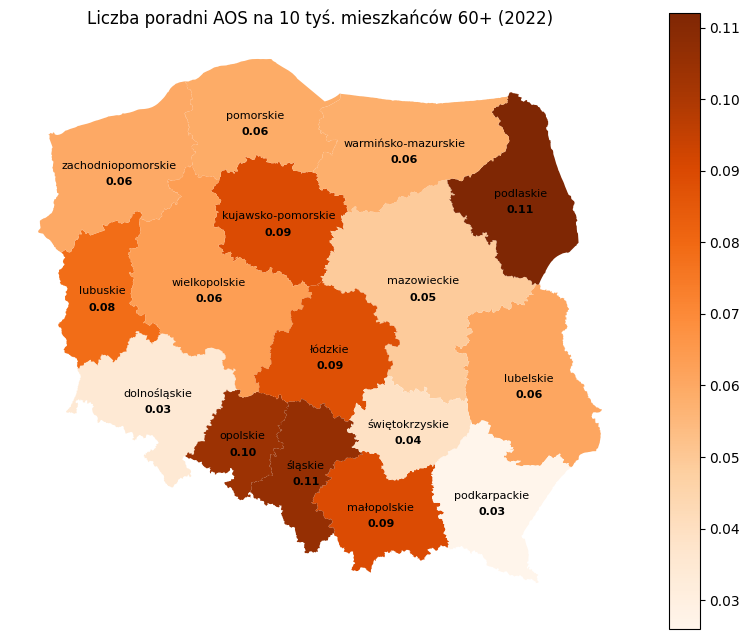

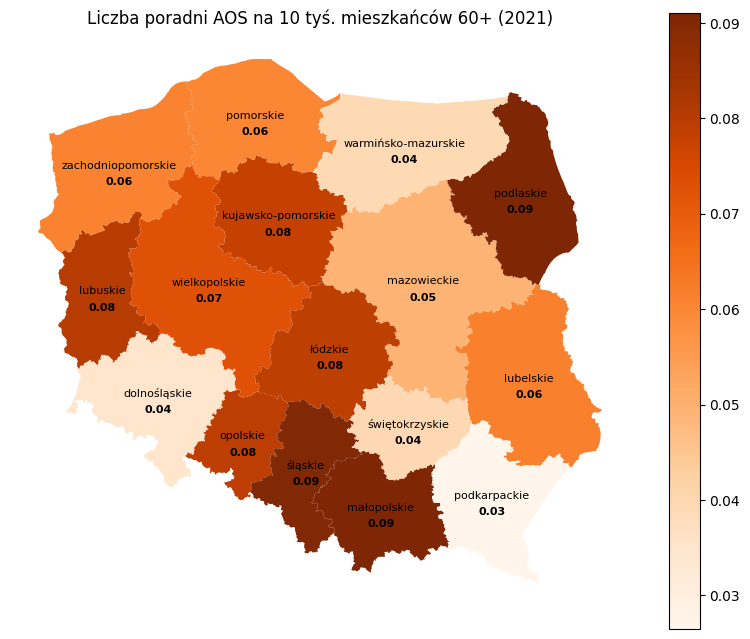

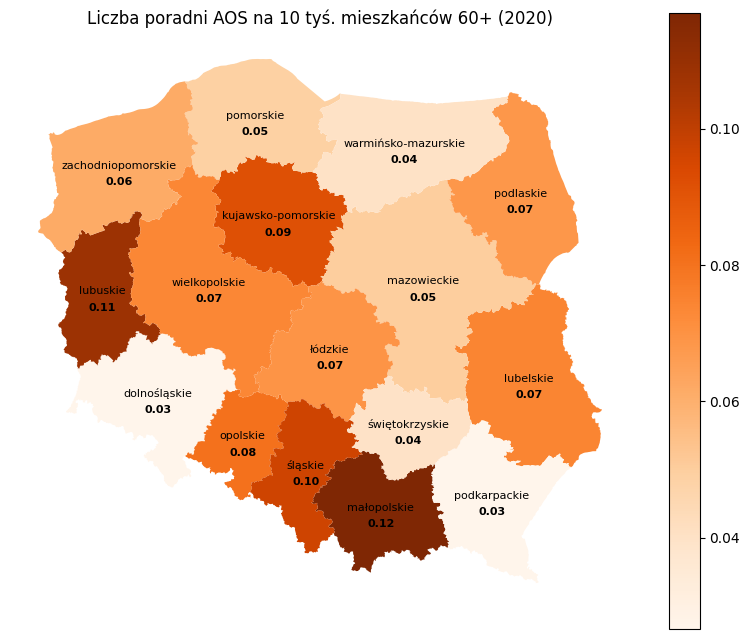

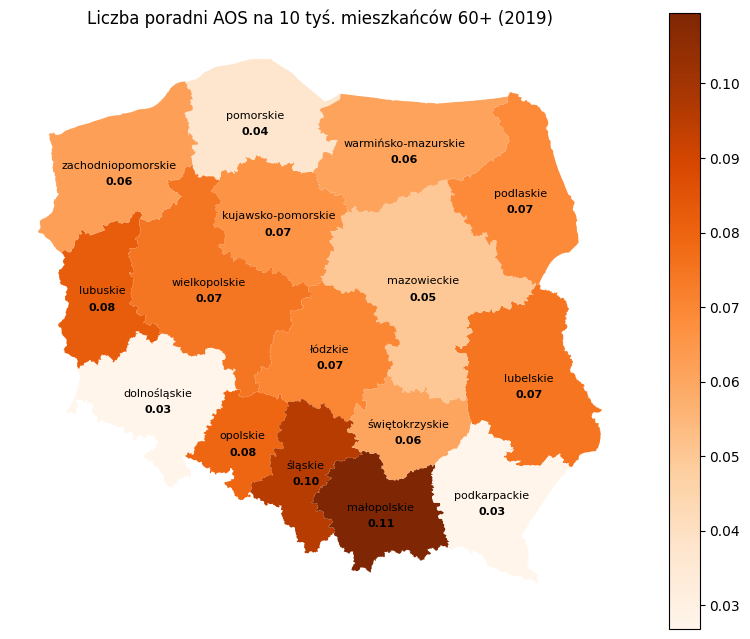

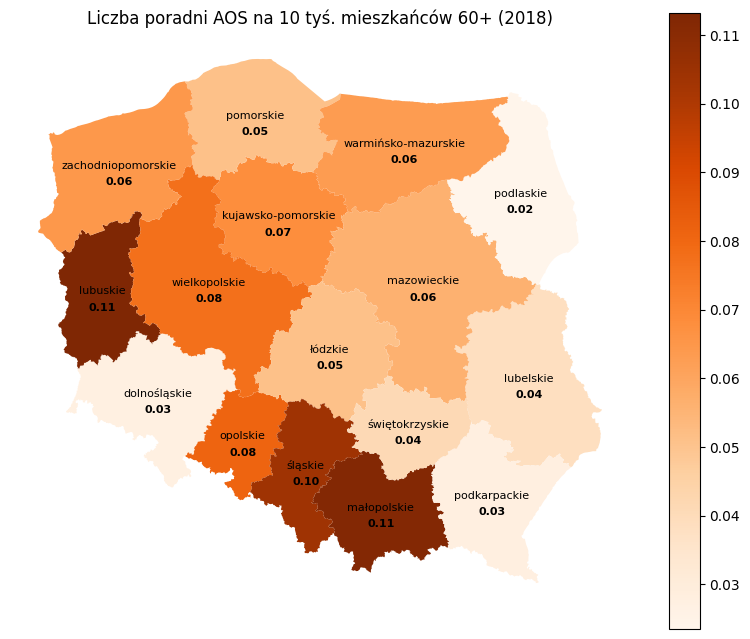

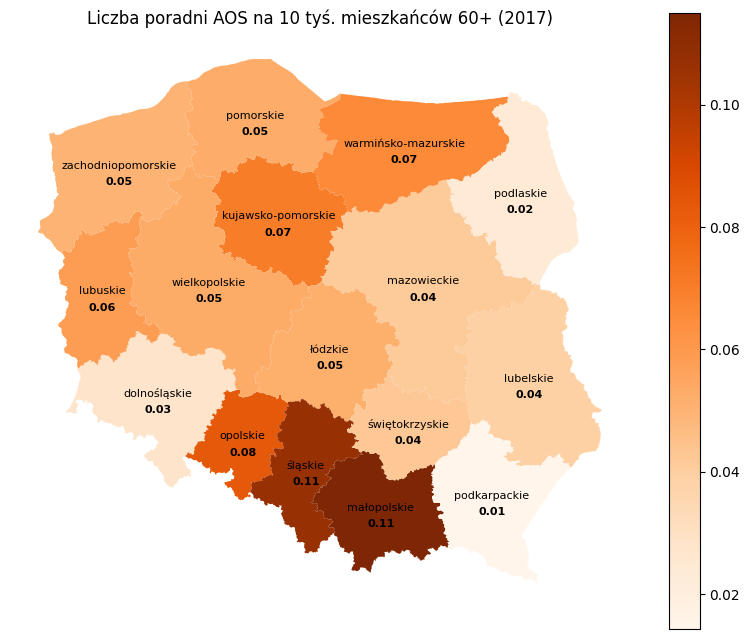

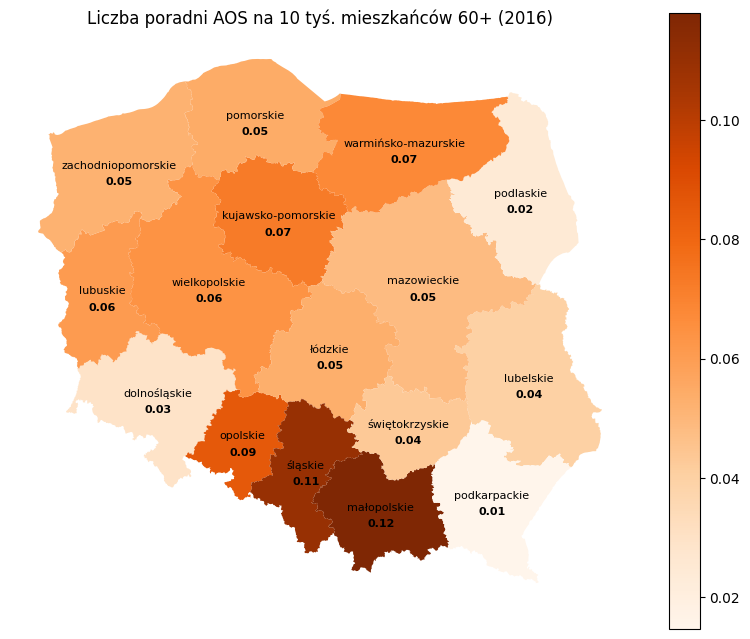

In [52]:
for year in years:
    update_map_poradnie(year)

In [53]:
def update_map_porady(year):

    filtered_gdf = gdf[gdf["Rok"] == year]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    filtered_gdf.plot(column="Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+", ax=ax, legend=True, cmap="Blues")
    
    ax.set_title(f"Liczba porad AOS na 1000 mieszkańców 60+ ({year})")
    ax.set_axis_off()
    
    for idx, row in filtered_gdf.iterrows():
        ax.annotate(text=row["Wojewodztwo"], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    horizontalalignment="center", fontsize=8, color="black")
        ax.annotate(text=f"{row['Liczba_Porad_AOS_Na_1tys_Mieszkancow_60+']:.2f}", xy=(row.geometry.centroid.x, row.geometry.centroid.y - 20000),
                    horizontalalignment="center", fontsize=8, color="black", weight="bold")
        
    fig.savefig(f"Output\porady_{year}.png")

    plt.show()

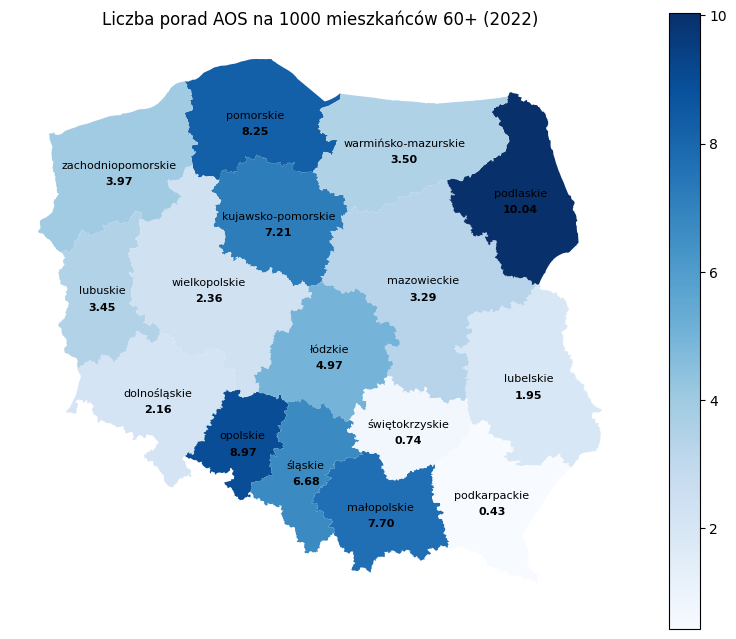

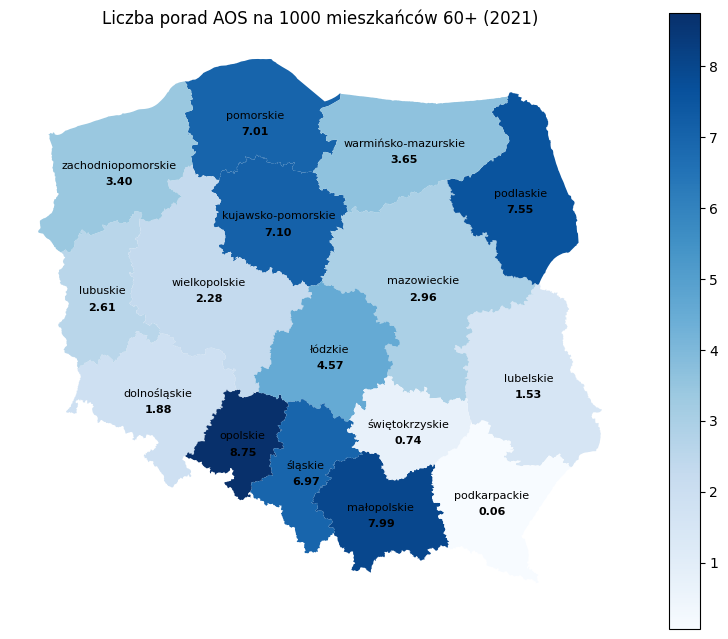

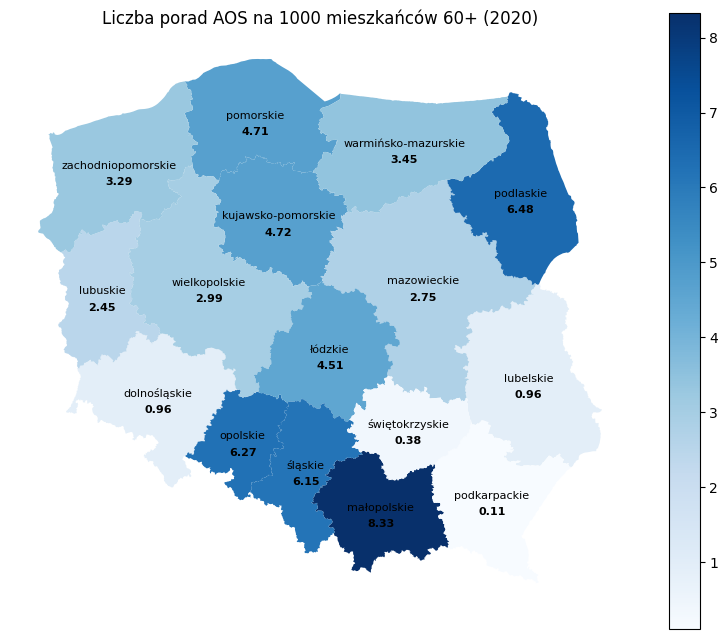

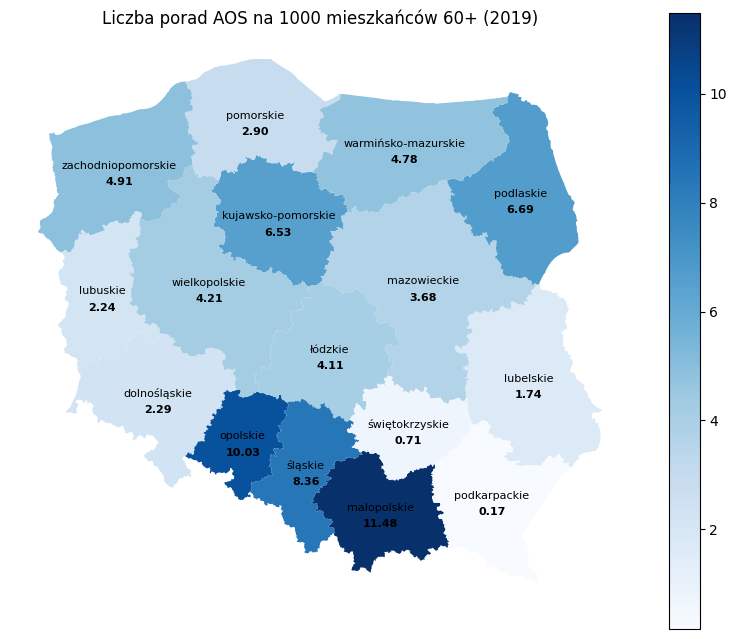

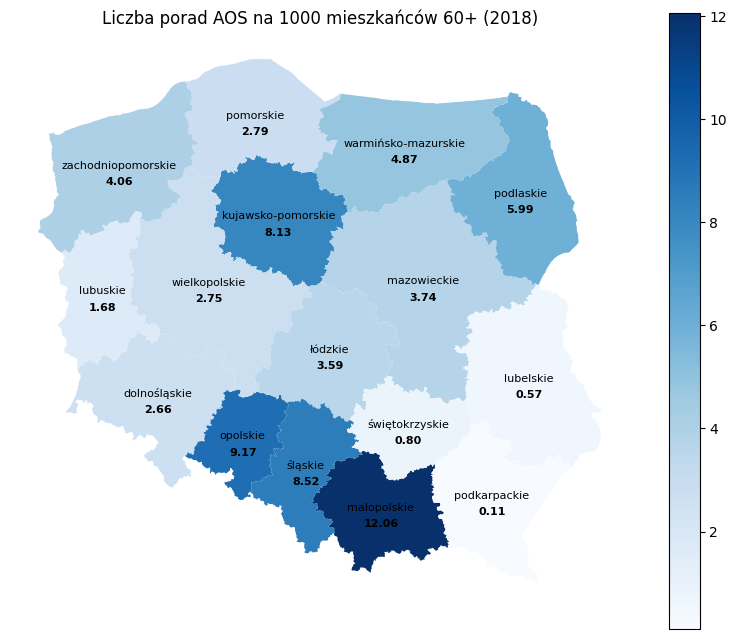

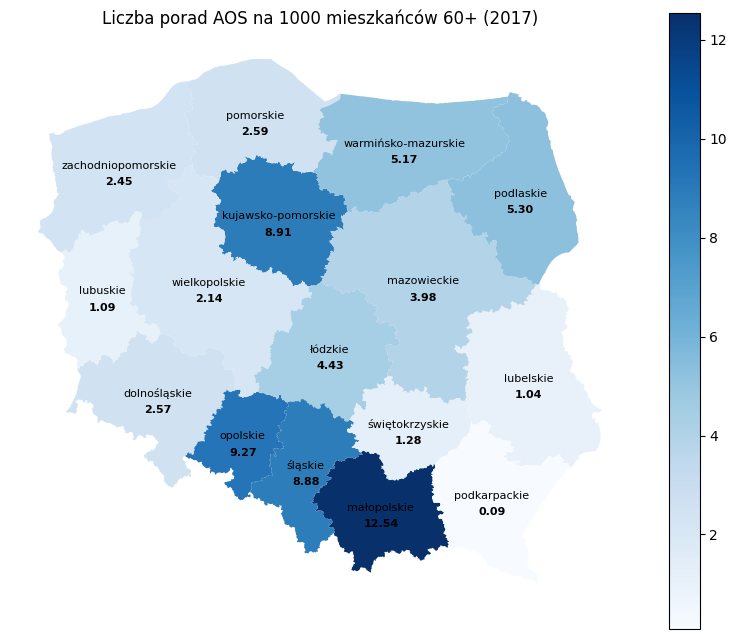

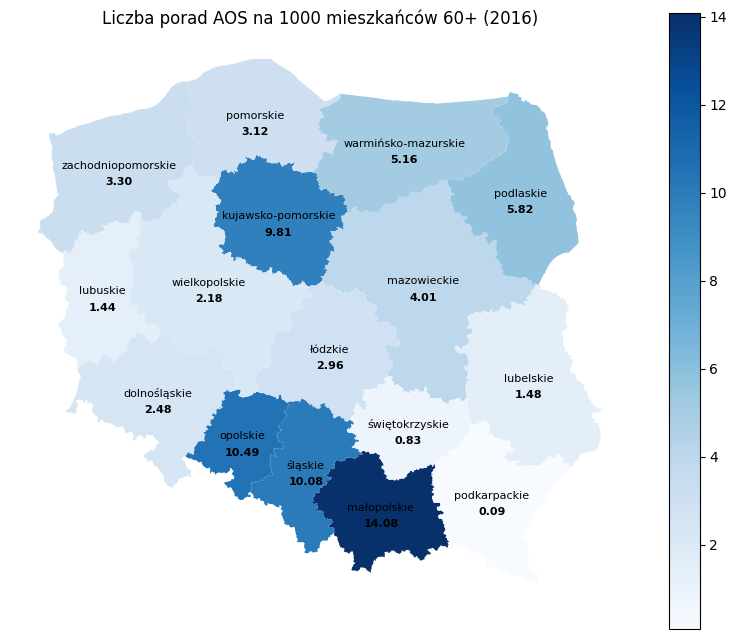

In [54]:
for year in years:
    update_map_porady(year)

# Analiza pakietu plików "problemy_zdrowotne_icd10"

In [55]:
# Ładuję pliki dotyczące problemów zdrowotnych wraz z ICD10 pobrane ze strony https://basiw.mz.gov.pl/mapy-informacje/mapa-2022-2026/analizy/ambulatoryjna-opieka-specjalistyczna/

years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
df_list = []

for year in years:
    file_path = f"Input\problemy_zdrowotne_icd10\problemy_zdrowotne_icd10_{year}.csv"
    df = pd.read_csv(file_path, encoding="utf-8")
    df_list.append(df)

df_pz_concat = pd.concat(df_list, ignore_index=True)

In [56]:
df_pz_concat.tail()

,Rok,Województwo,Specjalność komórki,Grupa wiekowa,Płeć,Kod ICD-10 poziom 3.,Nazwa ICD-10 poziom 3.,Kod ICD-10 poziom 2.,Nazwa ICD-10 poziom 2.,Kod ICD-10 poziom 1.,Nazwa ICD-10 poziom 1.,Liczba porad AOS
4245756,2022,świętokrzyskie,poradnia genetyczna,<18,Mężczyźni,Z86,Inne określone choroby w wywiadzie dotyczącym ...,Z80-Z99,Osoby z potencjalnym zagrożeniem zdrowia związ...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,2
4245757,2022,świętokrzyskie,poradnia immunologiczna dla dzieci,<18,Mężczyźni,Z87,W wywiadzie inne choroby i stany dotyczące dan...,Z80-Z99,Osoby z potencjalnym zagrożeniem zdrowia związ...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,1
4245758,2022,świętokrzyskie,poradnia gruźlicy i chorób płuc dla dzieci,<18,Mężczyźni,Z94,Transplantacja narządu lub tkanki,Z80-Z99,Osoby z potencjalnym zagrożeniem zdrowia związ...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,2
4245759,2022,świętokrzyskie,poradnia chirurgii urazowo-ortopedycznej dla d...,<18,Mężczyźni,Z96,Obecność innych wszczepów czynnościowych,Z80-Z99,Osoby z potencjalnym zagrożeniem zdrowia związ...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,2
4245760,2022,świętokrzyskie,poradnia chirurgii ogólnej dla dzieci,<18,Mężczyźni,Z98,Inne stany po zabiegach chirurgicznych,Z80-Z99,Osoby z potencjalnym zagrożeniem zdrowia związ...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,1


In [57]:
df_pz_concat.rename(columns={
                                "Województwo": "Wojewodztwo",
                                "Specjalność komórki": "Specjalnosc_Komorki",
                                "Grupa wiekowa": "Grupa_Wiekowa",
                                "Płeć": "Plec",
                                "Kod ICD-10 poziom 3.": "Kod_ICD10_Poziom_3",
                                "Nazwa ICD-10 poziom 3.": "Nazwa_ICD10_Poziom_3",
                                "Kod ICD-10 poziom 2.": "Kod_ICD10_Poziom_2",
                                "Nazwa ICD-10 poziom 2.": "Nazwa_ICD10_Poziom_2",
                                "Kod ICD-10 poziom 1.": "Kod_ICD10_Poziom_1",
                                "Nazwa ICD-10 poziom 1.": "Nazwa_ICD10_Poziom_1",
                                "Liczba porad AOS": "Liczba_Porad_AOS",
                                }, inplace=True)

In [58]:
# Filtruję po kolumnie "Specjalnosc_Komorki" wszystkie rekordy zawierające słowo "geriatr" bez względu na wielkość liter

df_pz_geriatria = df_pz_concat[df_pz_concat["Specjalnosc_Komorki"].str.contains("geriatr", case=False, na=False)]

In [59]:
df_pz_geriatria.reset_index(inplace=True)

In [60]:
df_pz_geriatria.drop("index", axis=1, inplace=True)

C:\Users\ktkat\AppData\Local\Temp\ipykernel_21128\1003057129.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
df_pz_geriatria.head(10)

,Rok,Wojewodztwo,Specjalnosc_Komorki,Grupa_Wiekowa,Plec,Kod_ICD10_Poziom_3,Nazwa_ICD10_Poziom_3,Kod_ICD10_Poziom_2,Nazwa_ICD10_Poziom_2,Kod_ICD10_Poziom_1,Nazwa_ICD10_Poziom_1,Liczba_Porad_AOS
0,2016,dolnośląskie,poradnia geriatryczna,40-64,Kobiety,E55,Niedobór witaminy D,E50-E64,Inne niedobory pokarmowe,E00-E90,"Zaburzenia wydzielania wewnętrznego, stanu odż...",1
1,2016,dolnośląskie,poradnia geriatryczna,40-64,Kobiety,F00,Otępienie w chorobie Alzheimera (G30.-+),F00-F09,"Zaburzenia psychiczne organiczne, włącznie z z...",F00-F99,Zaburzenia psychiczne i zaburzenia zachowania,1
2,2016,dolnośląskie,poradnia geriatryczna,40-64,Kobiety,I10,Samoistne (pierwotne) nadciśnienie,I10-I15,Nadciśnienie tętnicze,I00-I99,Choroby układu krążenia,1
3,2016,dolnośląskie,poradnia geriatryczna,40-64,Kobiety,R00,"Zaburzenia ""bicia"" serca",R00-R09,Objawy i cechy chorobowe dotyczące układu krąż...,R00-R99,"Objawy, cechy chorobowe oraz nieprawidłowe wyn...",1
4,2016,dolnośląskie,poradnia geriatryczna,40-64,Mężczyźni,E12,Cukrzyca związana z niedożywieniem,E10-E14,Cukrzyca,E00-E90,"Zaburzenia wydzielania wewnętrznego, stanu odż...",1
5,2016,dolnośląskie,poradnia geriatryczna,65+,Kobiety,B18,Przewlekłe wirusowe zapalenie wątroby,B15-B19,Wirusowe zapalenie wątroby,A00-B99,Wybrane choroby zakaźne i pasożytnicze,3
6,2016,dolnośląskie,poradnia geriatryczna,65+,Kobiety,C16,Nowotwór złośliwy żołądka,C15-C26,Nowotwory złośliwe narządów układu pokarmowego,C00-D48,Nowotwory,2
7,2016,dolnośląskie,poradnia geriatryczna,65+,Kobiety,C64,Nowotwór złośliwy nerki za wyjątkiem miedniczk...,C64-C68,Nowotwory złośliwe układu moczowego,C00-D48,Nowotwory,1
8,2016,dolnośląskie,poradnia geriatryczna,65+,Kobiety,C71,Nowotwór złośliwy mózgu,C69-C72,"Nowotwory złośliwe oka, mózgu i innych części ...",C00-D48,Nowotwory,6
9,2016,dolnośląskie,poradnia geriatryczna,65+,Kobiety,D43,Nowotwór o niepewnym lub nieznanym charakterze...,D37-D48,Nowotwory o niepewnym lub nieznanym charakterz...,C00-D48,Nowotwory,1


In [62]:
# Sprawdzam unikalne wartości po filtracji

df_pz_geriatria["Specjalnosc_Komorki"].unique()

array(['poradnia geriatryczna'], dtype=object)

In [63]:
df_pz_geriatria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28923 entries, 0 to 28922
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Rok                   28923 non-null  int64 
 1   Wojewodztwo           28923 non-null  object
 2   Specjalnosc_Komorki   28923 non-null  object
 3   Grupa_Wiekowa         28923 non-null  object
 4   Plec                  28923 non-null  object
 5   Kod_ICD10_Poziom_3    28923 non-null  object
 6   Nazwa_ICD10_Poziom_3  28923 non-null  object
 7   Kod_ICD10_Poziom_2    28923 non-null  object
 8   Nazwa_ICD10_Poziom_2  28923 non-null  object
 9   Kod_ICD10_Poziom_1    28923 non-null  object
 10  Nazwa_ICD10_Poziom_1  28923 non-null  object
 11  Liczba_Porad_AOS      28923 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 2.6+ MB


In [64]:
# Sprawdzam czy są jakieś duplikaty

df_pz_geriatria.duplicated().sum()

0

In [65]:
# Chcę zweryfikować czy liczba porad pokrywa się z tym co uzyskałam w poprzednim pliku. Agreguję Liczbę porad po roku.

df_pz_geriatria_porady_by_year = df_pz_geriatria.groupby("Rok")[["Liczba_Porad_AOS"]].sum()
df_pz_geriatria_porady_by_year

,Liczba_Porad_AOS
Rok,
2016,68610
2017,65680
2018,66116
2019,69749
2020,54000
2021,62227
2022,67407


In [66]:
# Wyświetlam dane z poprzedniej ramki, już widać że są różnice

df_aos_geriatria_grouped_by_year[["Rok","Liczba_Porad_AOS"]]

,Rok,Liczba_Porad_AOS
0,2016,68584
1,2017,65661
2,2018,66076
3,2019,69696
4,2020,53971
5,2021,62211
6,2022,67382


In [67]:
# robię merge ramek danych dla wybranych kolumn

df_pz_merged = pd.merge(df_pz_geriatria_porady_by_year, df_aos_geriatria_grouped_by_year[["Rok","Liczba_Porad_AOS"]], on="Rok")
df_pz_merged

,Rok,Liczba_Porad_AOS_x,Liczba_Porad_AOS_y
0,2016,68610,68584
1,2017,65680,65661
2,2018,66116,66076
3,2019,69749,69696
4,2020,54000,53971
5,2021,62227,62211
6,2022,67407,67382


In [68]:
# Dodaję kolumnę w której liczę różnicę

df_pz_merged["Roznica"] = df_pz_merged["Liczba_Porad_AOS_x"] - df_pz_merged["Liczba_Porad_AOS_y"]
df_pz_merged

,Rok,Liczba_Porad_AOS_x,Liczba_Porad_AOS_y,Roznica
0,2016,68610,68584,26
1,2017,65680,65661,19
2,2018,66116,66076,40
3,2019,69749,69696,53
4,2020,54000,53971,29
5,2021,62227,62211,16
6,2022,67407,67382,25


In [69]:
# Liczę sumę różnic

df_pz_merged["Roznica"].sum()

208

> Zakładam że taka różnica nie stanowi dużego procenta wszystkich wizyt więc ją pomijam ponieważ nie mam pełnego wglądu w bazę danych

In [70]:
# Sprawdzam w jakim wieku są pacjenci którzy skorzystali z wizyt w poradniach geriatrycznych

df_pz_geriatria_porady_by_age = df_pz_geriatria.groupby("Grupa_Wiekowa")[["Liczba_Porad_AOS"]].sum().sort_values(by="Liczba_Porad_AOS", ascending=False)
df_pz_geriatria_porady_by_age = df_pz_geriatria_porady_by_age.reset_index()
df_pz_geriatria_porady_by_age

,Grupa_Wiekowa,Liczba_Porad_AOS
0,65+,437639
1,40-64,16148
2,<18,2


In [71]:
fig_porady_wiek = px.bar(       
                                df_pz_geriatria_porady_by_age, 
                                x="Grupa_Wiekowa", 
                                y="Liczba_Porad_AOS", 
                                title="<b>Liczba Porad AOS według Grupy Wiekowej", 
                                labels={"Grupa_Wiekowa": "<b>Grupa Wiekowa", "Liczba_Porad_AOS": "<b>Liczba Porad AOS"}, 
                                color="Grupa_Wiekowa",
                                color_discrete_map={
                                                    "65+": "#597AFF",
                                                    "40-64": "#D8A900",
                                                    "<18": "#43D565"
                                                    },
                                height=500, 
                                width=700,
                                )

fig_porady_wiek.update_traces(
                                marker=dict(line=dict(color="gray", width=0.7)),
                                width=0.5,
                                hovertemplate="Grupa wiekowa: <b>%{x}</b> <br>Liczba porad: <b>%{y}</b>",
                                texttemplate="<b>%{y}",
                                textposition="outside"
                                )

fig_porady_wiek.update_layout(
                                yaxis=dict(
                                            tickformat=",",
                                            showgrid=True,
                                            gridcolor="lightgray"
                                            ),
                                hoverlabel_align="left",
                                plot_bgcolor="white",
                                paper_bgcolor="white",
                                xaxis=dict(
                                            showgrid=False,
                                            gridcolor="lightgray"
                                            )
                                )

fig_porady_wiek.show()

c:\Users\ktkat\pyver\py383\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [72]:
# Sprawdzam jakiej płci są pacjenci którzy skorzystali z wizyt w poradniach geriatrycznych

df_pz_geriatria_porady_by_sex = df_pz_geriatria.groupby("Plec")[["Liczba_Porad_AOS"]].sum()
df_pz_geriatria_porady_by_sex = df_pz_geriatria_porady_by_sex.reset_index()
df_pz_geriatria_porady_by_sex

,Plec,Liczba_Porad_AOS
0,Kobiety,322766
1,Mężczyźni,131023


In [73]:
fig_porady_plec = px.pie(   df_pz_geriatria_porady_by_sex, 
                            values="Liczba_Porad_AOS", 
                            names="Plec", 
                            title="<b>Liczba Porad AOS według Płci", 
                            labels={"Plec": "Płeć", "Liczba_Porad_AOS": "Liczba Porad AOS"},
                            color="Plec",
                            color_discrete_map={
                                                "Kobiety": "#597AFF",
                                                "Mężczyźni": "#D8A900",
                                                },
                            height=500, 
                            width=500,)

fig_porady_plec.update_traces(textposition="inside", textinfo="percent+label")

fig_porady_plec.show()

In [74]:
# Agreguję zarówno po wieku i płci

df_pz_geriatria_porady_by_age_and_sex = df_pz_geriatria.groupby(["Grupa_Wiekowa","Plec"])[["Liczba_Porad_AOS"]].sum()
df_pz_geriatria_porady_by_age_and_sex

Liczba_Porad_AOS
Grupa_Wiekowa Plec                       
40-64         Kobiety               10079
              Mężczyźni              6069
65+           Kobiety              312686
              Mężczyźni            124953
<18           Kobiety                   1
              Mężczyźni                 1

In [75]:
# Sprawdzam z jakiego typu chorobami borykają się pacjenci poradni geriatrycznych

df_pz_geriatria_porady_by_icd10_poz1 = df_pz_geriatria.groupby("Nazwa_ICD10_Poziom_1")[["Liczba_Porad_AOS"]].sum()
df_pz_geriatria_porady_by_icd10_poz1 = df_pz_geriatria_porady_by_icd10_poz1.sort_values(by="Liczba_Porad_AOS", ascending=False)
df_pz_geriatria_porady_by_icd10_poz1

,Liczba_Porad_AOS
Nazwa_ICD10_Poziom_1,
Choroby układu krążenia,157061
Zaburzenia psychiczne i zaburzenia zachowania,115222
Choroby układu nerwowego,42955
"Zaburzenia wydzielania wewnętrznego, stanu odżywienia i przemian metabolicznych",37469
Choroby układu mięśniowo-szkieletowego i tkanki łącznej,36959
"Objawy, cechy chorobowe oraz nieprawidłowe wyniki badań klinicznych i laboratoryjnych niesklasyfikowane gdzie indziej",17170
Czynniki wpływające na stan zdrowia i kontakt ze służbą zdrowia,10274
Choroby układu pokarmowego,8376
Choroby układu moczowo-płciowego,7357


In [76]:
df_pz_geriatria_porady_by_icd10_poz1 = df_pz_geriatria_porady_by_icd10_poz1.reset_index()

In [77]:
fig_porady_icd10 = px.bar(
                                df_pz_geriatria_porady_by_icd10_poz1,
                                x="Liczba_Porad_AOS",
                                y="Nazwa_ICD10_Poziom_1",
                                orientation="h",
                                title="<b>Liczba Porad AOS według kategorii ICD-10",
                                labels={"Nazwa_ICD10_Poziom_1": "<b>Kategoria ICD-10", "Liczba_Porad_AOS": "<b>Liczba Porad AOS"},
                                height=700,
                                width=1600,
                                color="Liczba_Porad_AOS",
                                color_continuous_scale="Blues",
                                )

fig_porady_icd10.update_traces(
                                marker=dict(line=dict(color="gray", width=0.7)),
                                texttemplate="<b>%{x}",
                                textposition="outside",
                                showlegend=False
                                )

fig_porady_icd10.update_layout(
                                yaxis=dict(categoryorder="total ascending", showgrid=False),
                                xaxis=dict(
                                            tickformat=",",
                                            showgrid=True,
                                            gridcolor="lightgray",
                                            range=[0, 180000],
                                            dtick=20000
                                            ),
                                hoverlabel_align="left",
                                plot_bgcolor="white",
                                paper_bgcolor="white"
                                )

fig_porady_icd10.show()

# Analiza pakietu plików "statystyki_porad"

In [78]:
# Ładuję pliki dotyczące problemów zdrowotnych wraz z ICD10 pobrane ze strony https://basiw.mz.gov.pl/mapy-informacje/mapa-2022-2026/analizy/ambulatoryjna-opieka-specjalistyczna/

# Wczytywanie plików w pętli i zapis do jednego df

years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
df_list = []

for year in years:
    file_path = f"Input\statystyki_porad/statystyki_porad_{year}.csv"
    df = pd.read_csv(file_path, encoding="utf-8")
    df_list.append(df)

df_sp_concat = pd.concat(df_list, ignore_index=True)

In [79]:
df_sp_concat.tail()

,Nazwa świadczeniodawcy,Województwo,Powiat,Gmina,Specjalność komórki,Miesiąc,Rok,Kod ICD-10 poziom 3.,Nazwa ICD-10 poziom 3.,Kod ICD-10 poziom 2.,Nazwa ICD-10 poziom 2.,Kod ICD-10 poziom 1.,Nazwa ICD-10 poziom 1.,Liczba porad AOS
50712606,NaN,NaN,świecki,NaN,poradnia położniczo-ginekologiczna,12,2022,O28,Nieprawidłowe wyniki przedporodowych rutynowyc...,O20-O29,Inne zaburzenia u ciężarnej związane głównie z...,O00-O99,"Ciąża, poród i okres połogu",1
50712607,NaN,NaN,świecki,NaN,poradnia położniczo-ginekologiczna,12,2022,Z03,Obserwacja medyczna i ocena przypadków podejrz...,Z00-Z13,Osoby stykające się ze służbą zdrowia w związk...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,15
50712608,NaN,NaN,świecki,NaN,poradnia położniczo-ginekologiczna,12,2022,Z12,Specjalne badanie przesiewowe w kierunku nowot...,Z00-Z13,Osoby stykające się ze służbą zdrowia w związk...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,5
50712609,NaN,NaN,świecki,NaN,poradnia położniczo-ginekologiczna,12,2022,Z34,Nadzór nad ciążą prawidłową,Z30-Z39,Osoby wymagające opieki zdrowotnej w okoliczno...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,2
50712610,NaN,NaN,świecki,NaN,poradnia położniczo-ginekologiczna,12,2022,Z39,Opieka i badanie poporodowe,Z30-Z39,Osoby wymagające opieki zdrowotnej w okoliczno...,Z00-Z99,Czynniki wpływające na stan zdrowia i kontakt ...,1


In [80]:
df_sp_concat.shape

(50712611, 14)

In [81]:
df_sp_concat.rename(columns={
                                "Nazwa świadczeniodawcy": "Nazwa_Swiadczeniodawcy",
                                "Województwo": "Wojewodztwo",
                                "Specjalność komórki": "Specjalnosc_Komorki",
                                "Miesiąc": "Miesiac",
                                "Kod ICD-10 poziom 3.": "Kod_ICD10_Poziom_3",
                                "Nazwa ICD-10 poziom 3.": "Nazwa_ICD10_Poziom_3",
                                "Kod ICD-10 poziom 2.": "Kod_ICD10_Poziom_2",
                                "Nazwa ICD-10 poziom 2.": "Nazwa_ICD10_Poziom_2",
                                "Kod ICD-10 poziom 1.": "Kod_ICD10_Poziom_1",
                                "Nazwa ICD-10 poziom 1.": "Nazwa_ICD10_Poziom_1",
                                "Liczba porad AOS": "Liczba_Porad_AOS",
                                }, inplace=True)

In [82]:
# Filtruję po kolumnie "Specjalnosc_Komorki" wszystkie rekordy zawierające słowo "geriatr" bez względu na wielkość liter

df_sp_geriatria = df_sp_concat[df_sp_concat["Specjalnosc_Komorki"].str.contains("geriatr", case=False, na=False)]

In [83]:
df_sp_geriatria.tail()

,Nazwa_Swiadczeniodawcy,Wojewodztwo,Powiat,Gmina,Specjalnosc_Komorki,Miesiac,Rok,Kod_ICD10_Poziom_3,Nazwa_ICD10_Poziom_3,Kod_ICD10_Poziom_2,Nazwa_ICD10_Poziom_2,Kod_ICD10_Poziom_1,Nazwa_ICD10_Poziom_1,Liczba_Porad_AOS
50697514,Samodzielny Publiczny Zespół Zakładów Opieki Z...,świętokrzyskie,staszowski,Staszów,poradnia geriatryczna,12,2022,G30,Choroba Alzheimera,G30-G32,Inne choroby zwyrodnieniowe układu nerwowego,G00-G99,Choroby układu nerwowego,2
50697579,Samodzielny Publiczny Zespół Zakładów Opieki Z...,świętokrzyskie,staszowski,Staszów,poradnia geriatryczna,12,2022,I10,Samoistne (pierwotne) nadciśnienie,I10-I15,Nadciśnienie tętnicze,I00-I99,Choroby układu krążenia,3
50697581,Samodzielny Publiczny Zespół Zakładów Opieki Z...,świętokrzyskie,staszowski,Staszów,poradnia geriatryczna,12,2022,I11,Choroba nadciśnieniowa z zajęciem serca,I10-I15,Nadciśnienie tętnicze,I00-I99,Choroby układu krążenia,1
50697590,Samodzielny Publiczny Zespół Zakładów Opieki Z...,świętokrzyskie,staszowski,Staszów,poradnia geriatryczna,12,2022,I50,Niewydolność serca,I30-I52,Inne choroby serca,I00-I99,Choroby układu krążenia,7
50697596,Samodzielny Publiczny Zespół Zakładów Opieki Z...,świętokrzyskie,staszowski,Staszów,poradnia geriatryczna,12,2022,I69,Następstwa chorób naczyń mózgowych,I60-I69,Choroby naczyń mózgowych,I00-I99,Choroby układu krążenia,1


In [84]:
df_sp_geriatria.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129752 entries, 148607 to 50697596
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Nazwa_Swiadczeniodawcy  129752 non-null  object
 1   Wojewodztwo             129752 non-null  object
 2   Powiat                  129752 non-null  object
 3   Gmina                   129752 non-null  object
 4   Specjalnosc_Komorki     129752 non-null  object
 5   Miesiac                 129752 non-null  int64 
 6   Rok                     129752 non-null  int64 
 7   Kod_ICD10_Poziom_3      129752 non-null  object
 8   Nazwa_ICD10_Poziom_3    129752 non-null  object
 9   Kod_ICD10_Poziom_2      129752 non-null  object
 10  Nazwa_ICD10_Poziom_2    129752 non-null  object
 11  Kod_ICD10_Poziom_1      129752 non-null  object
 12  Nazwa_ICD10_Poziom_1    129752 non-null  object
 13  Liczba_Porad_AOS        129752 non-null  int64 
dtypes: int64(3), object(11)
memory usa

In [85]:
df_sp_geriatria.duplicated().sum()

0

In [86]:
# Sprawdzam ile jest unikalnych poradni (świadczeniodawców)

df_sp_geriatria_poradnie_by_year = df_sp_geriatria.groupby(["Rok"])[["Nazwa_Swiadczeniodawcy"]].nunique()
df_sp_geriatria_poradnie_by_year

,Nazwa_Swiadczeniodawcy
Rok,
2016,82
2017,80
2018,90
2019,94
2020,96
2021,93
2022,101


In [87]:
# Konfrontuję dane z poprzednio analizowaną ramką danych -> robię merge ramek danych dla wybranych kolumn

df_sp_merged = pd.merge(df_sp_geriatria_poradnie_by_year, df_aos_geriatria_grouped_by_year[["Rok","Liczba_Poradni_AOS"]], on="Rok")
df_sp_merged

,Rok,Nazwa_Swiadczeniodawcy,Liczba_Poradni_AOS
0,2016,82,82
1,2017,80,80
2,2018,90,90
3,2019,94,94
4,2020,96,97
5,2021,93,94
6,2022,101,101


In [88]:
# Dodaję kolumnę w której liczę różnicę

df_sp_merged["Roznica"] = df_sp_merged["Nazwa_Swiadczeniodawcy"] - df_sp_merged["Liczba_Poradni_AOS"]
df_sp_merged

,Rok,Nazwa_Swiadczeniodawcy,Liczba_Poradni_AOS,Roznica
0,2016,82,82,0
1,2017,80,80,0
2,2018,90,90,0
3,2019,94,94,0
4,2020,96,97,-1
5,2021,93,94,-1
6,2022,101,101,0


> Dane w większości pokrywają się, są dwie niewielkie różnice

# Analiza szpitali z oddziałami geriatrycznymi, pliki z GUS

In [89]:
# Ładuję plik dotyczący szpitali z oddziałami geriatrycznymi pobrany ze strony https://bdl.stat.gov.pl/bdl/dane/podgrup/temat

df_szpitale_geriatr = pd.read_csv(r"Input\K22.G261.P1808 Szpitale z oddziałami geriatrycznymi 2018-2022\OCHR_1808_CREL_20240705143116.csv", encoding="utf-8", sep=";")

In [90]:
df_szpitale_geriatr

,Kod,Nazwa,Zakres przedmiotowy,Rodzaje oddziałów,Rok,Wartosc,Jednostka miary,Atrybut,Unnamed: 8
0,0,POLSKA,oddziały,geriatryczne,2018,52,-,NaN,NaN
1,0,POLSKA,oddziały,geriatryczne,2019,52,-,NaN,NaN
2,0,POLSKA,oddziały,geriatryczne,2020,51,-,NaN,NaN
3,0,POLSKA,oddziały,geriatryczne,2021,51,-,NaN,NaN
4,0,POLSKA,oddziały,geriatryczne,2022,62,-,NaN,NaN
5,0,POLSKA,łóżka na oddziałach,geriatryczne,2018,1143,-,NaN,NaN
6,0,POLSKA,łóżka na oddziałach,geriatryczne,2019,1097,-,NaN,NaN
7,0,POLSKA,łóżka na oddziałach,geriatryczne,2020,1045,-,NaN,NaN
8,0,POLSKA,łóżka na oddziałach,geriatryczne,2021,1048,-,NaN,NaN
9,0,POLSKA,łóżka na oddziałach,geriatryczne,2022,1228,-,NaN,NaN


In [91]:
df_szpitale_geriatr = df_szpitale_geriatr[["Zakres przedmiotowy", "Rok", "Wartosc"]]

In [92]:
pd.options.mode.chained_assignment = None

In [93]:
df_szpitale_geriatr.rename(columns={"Zakres przedmiotowy" : "Zakres_przedmiotowy"}, inplace=True)

In [94]:
df_szpitale_geriatr_oddzialy = df_szpitale_geriatr[df_szpitale_geriatr["Zakres_przedmiotowy"] == "oddziały"]
df_szpitale_geriatr_oddzialy.rename(columns={"Wartosc":"Ilosc_oddzialow"}, inplace=True)

In [95]:
df_szpitale_geriatr_oddzialy

,Zakres_przedmiotowy,Rok,Ilosc_oddzialow
0,oddziały,2018,52
1,oddziały,2019,52
2,oddziały,2020,51
3,oddziały,2021,51
4,oddziały,2022,62


In [96]:
fig_szpitale_oddzialy = px.bar( 
                                    df_szpitale_geriatr_oddzialy, 
                                    x="Rok", 
                                    y="Ilosc_oddzialow", 
                                    title="<b>Ilość oddziałów geriatrycznych w szpitalach w latach 2018-2022", 
                                    labels={"Rok": "<b>Rok", "Ilosc_oddzialow": "<b>Ilość oddziałów"}, 
                                    height=500, 
                                    width=700,
                                    )

fig_szpitale_oddzialy.update_traces(
                                    marker=dict(line=dict(color="gray", width=0.7)),
                                    width=0.5,
                                    hovertemplate="Rok: <b>%{x}</b> <br>Ilość oddziałów: <b>%{y}</b>",
                                    texttemplate="<b>%{y}",
                                    textposition="outside"
                                    )

fig_szpitale_oddzialy.update_layout(
                                    yaxis=dict(
                                                tickformat=",",
                                                showgrid=True,
                                                gridcolor="lightgray"
                                                ),
                                    hoverlabel_align="left",
                                    plot_bgcolor="white",
                                    paper_bgcolor="white",
                                    xaxis=dict(
                                                showgrid=False,
                                                gridcolor="lightgray"
                                                )
                                    )

fig_szpitale_oddzialy.show()

In [97]:
df_szpitale_geriatr_lozka = df_szpitale_geriatr[df_szpitale_geriatr["Zakres_przedmiotowy"] == "łóżka na oddziałach"]
df_szpitale_geriatr_lozka.rename(columns={"Wartosc":"Ilosc_lozek"}, inplace=True)

In [98]:
df_szpitale_geriatr_lozka

,Zakres_przedmiotowy,Rok,Ilosc_lozek
5,łóżka na oddziałach,2018,1143
6,łóżka na oddziałach,2019,1097
7,łóżka na oddziałach,2020,1045
8,łóżka na oddziałach,2021,1048
9,łóżka na oddziałach,2022,1228


In [99]:
fig_szpitale_lozka = px.bar( 
                                    df_szpitale_geriatr_lozka, 
                                    x="Rok", 
                                    y="Ilosc_lozek", 
                                    title="<b>Ilość łóżek na oddziałach geriatrycznych w szpitalach <br>w latach 2018-2022", 
                                    labels={"Rok": "<b>Rok", "Ilosc_lozek": "<b>Ilość łóżekw"}, 
                                    height=500, 
                                    width=700,
                                    )

fig_szpitale_lozka.update_traces(
                                    marker=dict(line=dict(color="gray", width=0.7)),
                                    width=0.5,
                                    hovertemplate="Rok: <b>%{x}</b> <br>Ilość łóżek: <b>%{y}</b>",
                                    texttemplate="<b>%{y}",
                                    textposition="outside"
                                    )

fig_szpitale_lozka.update_layout(
                                    yaxis=dict(
                                                tickformat=",",
                                                showgrid=True,
                                                gridcolor="lightgray"
                                                ),
                                    hoverlabel_align="left",
                                    plot_bgcolor="white",
                                    paper_bgcolor="white",
                                    xaxis=dict(
                                                showgrid=False,
                                                gridcolor="lightgray"
                                                )
                                    )

fig_szpitale_lozka.show()

In [100]:
df_szpitale_geriatr_lozka = pd.merge(df_szpitale_geriatr_lozka, df_szpitale_geriatr_oddzialy[["Rok","Ilosc_oddzialow"]], on="Rok")
df_szpitale_geriatr_lozka

,Zakres_przedmiotowy,Rok,Ilosc_lozek,Ilosc_oddzialow
0,łóżka na oddziałach,2018,1143,52
1,łóżka na oddziałach,2019,1097,52
2,łóżka na oddziałach,2020,1045,51
3,łóżka na oddziałach,2021,1048,51
4,łóżka na oddziałach,2022,1228,62


In [101]:
df_szpitale_geriatr_lozka["Ilosc_lozer_per_oddzial"] = df_szpitale_geriatr_lozka["Ilosc_lozek"] / df_szpitale_geriatr_lozka["Ilosc_oddzialow"]
df_szpitale_geriatr_lozka

,Zakres_przedmiotowy,Rok,Ilosc_lozek,Ilosc_oddzialow,Ilosc_lozer_per_oddzial
0,łóżka na oddziałach,2018,1143,52,21.980769
1,łóżka na oddziałach,2019,1097,52,21.096154
2,łóżka na oddziałach,2020,1045,51,20.490196
3,łóżka na oddziałach,2021,1048,51,20.549020
4,łóżka na oddziałach,2022,1228,62,19.806452


In [102]:
fig_lozka_per_oddzial = go.Figure()

fig_lozka_per_oddzial.add_trace(go.Bar(
                                        x=df_szpitale_geriatr_lozka["Rok"],
                                        y=df_szpitale_geriatr_lozka["Ilosc_oddzialow"],
                                        name="Liczba Oddziałów",
                                        marker_color="#597AFF"
                                        ))

fig_lozka_per_oddzial.add_trace(go.Bar(
                                        x=df_szpitale_geriatr_lozka["Rok"],
                                        y=df_szpitale_geriatr_lozka["Ilosc_lozer_per_oddzial"],
                                        name="Liczba Łóżek per Oddział",
                                        marker_color="#D8A900"
                                        ))

fig_lozka_per_oddzial.update_traces(
                                        marker=dict(line=dict(color="gray", width=0.7)),
                                        width=0.4,
                                        hovertemplate="Rok: <b>%{x}</b> <br>Ilość łóżek: <b>%{y:.2f}</b>",
                                        texttemplate="<b>%{y:.2f}",
                                        textposition="outside"
                                        )

fig_lozka_per_oddzial.update_layout(
                                        title="<b>Liczba Oddziałów i Łóżek per Oddział w poszczególnych latach",
                                        xaxis=dict( title="<b>Rok",
                                                    showgrid=False,
                                                    gridcolor="lightgray"),
                                        yaxis=dict(title="<b>Liczba łóżek per Oddział",
                                                   showgrid=True,
                                                   gridcolor="lightgray"),
                                        height=600, 
                                        width=1000,
                                        hoverlabel_align="left",
                                        plot_bgcolor="white",
                                        paper_bgcolor="white",
        
                                        # barmode="stack"
                                    )

fig_lozka_per_oddzial.show()

In [103]:
df_szpitale_geriatr_pacjenci = df_szpitale_geriatr[df_szpitale_geriatr["Zakres_przedmiotowy"].str.contains("leczeni na oddziałach", case=False, na=False)]
df_szpitale_geriatr_pacjenci.rename(columns={"Wartosc":"Ilosc_pacjentow"}, inplace=True)

In [104]:
df_szpitale_geriatr_pacjenci

,Zakres_przedmiotowy,Rok,Ilosc_pacjentow
10,leczeni na oddziałach (łącznie z ruchem między...,2018,31881
11,leczeni na oddziałach (łącznie z ruchem między...,2019,32458
12,leczeni na oddziałach (łącznie z ruchem między...,2020,21860
13,leczeni na oddziałach (łącznie z ruchem między...,2021,21253
14,leczeni na oddziałach (łącznie z ruchem między...,2022,27458


In [105]:
fig_szpitale_pacjenci = px.bar( 
                                        df_szpitale_geriatr_pacjenci, 
                                        x="Rok", 
                                        y="Ilosc_pacjentow", 
                                        title="<b>Ilość pacjentów na oddziałach geriatrycznych w szpitalach <br>w latach 2018-2022", 
                                        labels={"Rok": "<b>Rok", "Ilosc_pacjentow": "<b>Ilość pacjentów"}, 
                                        height=500, 
                                        width=700,
                                        )

fig_szpitale_pacjenci.update_traces(
                                        marker=dict(line=dict(color="gray", width=0.7)),
                                        width=0.5,
                                        hovertemplate="Rok: <b>%{x}</b> <br>Ilość pacjentów: <b>%{y}</b>",
                                        texttemplate="<b>%{y}",
                                        textposition="outside"
                                        )

fig_szpitale_pacjenci.update_layout(
                                        yaxis=dict(
                                                    tickformat=",",
                                                    showgrid=True,
                                                    gridcolor="lightgray"
                                                    ),
                                        hoverlabel_align="left",
                                        plot_bgcolor="white",
                                        paper_bgcolor="white",
                                        xaxis=dict(
                                                    showgrid=False,
                                                    gridcolor="lightgray"
                                                    )
                                        )

fig_szpitale_pacjenci.show()

# Analiza szpitali i sanatoriów uzdrowiskowych, pliki z GUS

In [106]:
# Ładuję plik dotyczący szpitali i sanatoriów uzdrowiskowych pobrany ze strony https://bdl.stat.gov.pl/bdl/dane/podgrup/temat

df_szpitale_sanatoria = pd.read_csv(r"Input\K22.G262.P2492 Szpitale i sanatoria uzdrowiskowe, wiek 65+, 2018-2022\OCHR_2492_CREL_20240705143736.csv", encoding="utf-8", sep=";")

In [107]:
df_szpitale_sanatoria

,Kod,Nazwa,Wykaz,Rok,Wartosc,Jednostka miary,Atrybut,Unnamed: 7
0,0,POLSKA,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2018,NaN,osoba,NaN,NaN
1,0,POLSKA,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2019,NaN,osoba,NaN,NaN
2,0,POLSKA,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2020,185021.0,osoba,NaN,NaN
3,0,POLSKA,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2021,278789.0,osoba,NaN,NaN
4,0,POLSKA,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2022,415206.0,osoba,NaN,NaN
5,0,POLSKA,liczba dni pobytu kuracjuszy w wieku 65 lat i ...,2018,NaN,osoba/dz.,NaN,NaN
6,0,POLSKA,liczba dni pobytu kuracjuszy w wieku 65 lat i ...,2019,NaN,osoba/dz.,NaN,NaN
7,0,POLSKA,liczba dni pobytu kuracjuszy w wieku 65 lat i ...,2020,3137082.0,osoba/dz.,NaN,NaN
8,0,POLSKA,liczba dni pobytu kuracjuszy w wieku 65 lat i ...,2021,4581240.0,osoba/dz.,NaN,NaN
9,0,POLSKA,liczba dni pobytu kuracjuszy w wieku 65 lat i ...,2022,6730933.0,osoba/dz.,NaN,NaN


In [108]:
df_szpitale_sanatoria.rename(columns={"Jednostka miary" : "Jednostka_miary"}, inplace=True)

In [109]:
df_szpitale_sanatoria_pacjenci = df_szpitale_sanatoria[df_szpitale_sanatoria["Wykaz"].str.contains("kuracjusze leczeni ", case=False, na=False)]
df_szpitale_sanatoria_pacjenci.rename(columns={"Wartosc":"Ilosc_pacjentow"}, inplace=True)

In [110]:
df_szpitale_sanatoria_pacjenci = df_szpitale_sanatoria_pacjenci[["Wykaz", "Rok", "Ilosc_pacjentow"]]
df_szpitale_sanatoria_pacjenci

,Wykaz,Rok,Ilosc_pacjentow
0,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2018,NaN
1,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2019,NaN
2,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2020,185021.0
3,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2021,278789.0
4,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2022,415206.0


In [111]:
df_szpitale_sanatoria_pacjenci.dropna(inplace=True)

In [112]:
df_szpitale_sanatoria_pacjenci = df_szpitale_sanatoria_pacjenci.reset_index()
df_szpitale_sanatoria_pacjenci = df_szpitale_sanatoria_pacjenci.drop("index", axis=1)
df_szpitale_sanatoria_pacjenci

,Wykaz,Rok,Ilosc_pacjentow
0,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2020,185021.0
1,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2021,278789.0
2,kuracjusze leczeni stacjonarnie w wieku 65 lat...,2022,415206.0


In [113]:
fig_sanatoria_pacjenci = px.bar( 
                                        df_szpitale_sanatoria_pacjenci, 
                                        x="Rok", 
                                        y="Ilosc_pacjentow", 
                                        title="<b>Ilość kuracjuszy w wieku 65+ w sanatoriach <br>w latach 2020-2022", 
                                        labels={"Rok": "<b>Rok", "Ilosc_pacjentow": "<b>Ilość kuracjuszy 65+"}, 
                                        height=500, 
                                        width=700,
                                        )

fig_sanatoria_pacjenci.update_traces(
                                        marker=dict(line=dict(color="gray", width=0.7)),
                                        width=0.5,
                                        hovertemplate="Rok: <b>%{x}</b> <br>Ilość kuracjuszy 65+: <b>%{y}</b>",
                                        texttemplate="<b>%{y}",
                                        textposition="outside"
                                        )

fig_sanatoria_pacjenci.update_layout(
                                        yaxis=dict(
                                                    tickformat=",",
                                                    showgrid=True,
                                                    gridcolor="lightgray"
                                                    ),
                                        hoverlabel_align="left",
                                        plot_bgcolor="white",
                                        paper_bgcolor="white",
                                        xaxis=dict(
                                                    showgrid=False,
                                                    gridcolor="lightgray",
                                                    dtick=1
                                                    )
                                        )

fig_sanatoria_pacjenci.show()

# Raport o stanie opieki zdrowotnej w zakresie opieki geriatrycznej

## Wstęp
    Opieka geriatryczna jest kluczowym elementem systemu opieki zdrowotnej, zwłaszcza w kontekście starzejącej się populacji. Niniejszy raport przedstawia stan opieki geriatrycznej w Polsce do 2022 roku, koncentrując się na liczbie oddziałów oraz poradni geriatrycznych, a także liczbie udzielonych świadczeń. Dodatkowo, w raporcie znajdują się informacje na temat grupy świadczeniobiorców oraz porównanie z latami ubiegłymi, co pozwala na ocenę trendów i zmian w zakresie dostępności oraz jakości opieki geriatrycznej.

    Do sporządzenia analiz zostały użyte ogólnodostępne źródła danych znajdujących się na stronie Ministerstwa Zdrowia, z Bazy Analiz Systemowych i Wdrożeniowych oraz ze strony Głównego Urzędu Statystycznego z Bazy Danych Lokalnych. Niektóre źródła danych zawierały inny podział wiekowy, dlatego został użyty najbliższy związany z tematyką raportu.

### Liczba oddziałów geriatrycznych
    W roku 2022 liczba oddziałów geriatrycznych w Polsce wyniosła 62, co stanowi wzrost o 22% w porównaniu z rokiem 2021, kiedy to funkcjonowało 51 oddziałów. Ten znaczący wzrost nastąpił po dłuższej stagnacji, bowiem od roku 2018 liczba oddziałów wynosiła od 51 do 52.
    Podobną tendencję można zaobserwować z liczbą łóżek, ta w 2022 również wzrasta, ale porównując liczbę dostępnych łóżek do liczby oddziałów widać, że pomimo wzrostu liczby oddziałów, liczba łóżek spadła, i od 2018 roku gdzie przypadało 21 łóżek na oddział stanowi najniższy wynik równy 19 łóżek na oddział.

### Liczba pacjentów na oddziałach geriatrycznych
    Najwięcej pacjentów oddziałów geriatrycznych przyjęto w latach 2018 i 2019 bo około 32 tysiące na rok, natomiast w roku 2020 kiedy rozpoczęła się pandemia COVID-19 można zaobserwować znaczny spadek liczby pacjentów do około 21-22 tysięcy na rok, czego przyczyną jest zarówno ograniczenie wizyt szpitalnych do koniecznych celem zmiejszenia ryzyka zakażenia, jak również strach wśród osób starszych przed możliwością zachorowania w placówce medycznej.
    Natomiast w roku 2020 liczba pacjentów wzrosła do 27,5 tysiąca.

### Liczba pacjentów w szpitalach i sanatoriach uzdrowiskowych
    Dane dotyczące szpitali i sanatoriów uzdrowiskowych pozyskane z GUS są przedstawione jedynie za okres 2020-2022 i dotyczą osób w wieku w wieku 65 lat i więcej. Jak można zaobserwować, liczba kuracujszy sukcesywnie rośnie o około 50% z roku na rok. Może to świadczyć zarówno o zwięszkonej dostępności do usług ze względu na zniesienie ograniczeń związanych z COVID-19 jak i koniecznością dodatkowej opieki specjalistycznej po przebytych infekcjach COVID-19.

### Liczba poradni geriatrycznych
    W 2022 roku w Polsce działało 101 poradni geriatrycznych, co oznacza wzrost o 7% w porównaniu do roku 2021, kiedy to liczba poradni wynosiła 94 oraz 23% wzrostu w porównaniu do roku 2016 w którym dostępne były tylko 82 poradnie. W roku 2020, kiedy wybuchła pandemia COVID-19, zarejestrowano działaność 97. poradni, co stanowi 4% wzrost w porównaniu do roku ubiegłego, jednak trudna do przewidzenia sytuacja epidemiologiczna zweryfikowała dostępność do tych usług.

    Analizując dostęp do poradni geriatrycznych na każde 10 tysięcy mieszkańców zostały dołączone dane z GUS o liczbie ludności w wieku 60+ zamieszkującej dane województwo, aby móc uwzględnieć dostępność do wybranych usług dla właściwej grupy wiekowej. Osoby starsze, stosownie do uregulowań ustawy z dnia 11 września 2015 r. o osobach starszych, to osoby w wieku 60 lat i więcej. Mimo powrzechnie ustalonego wieku z opieki w poradniach geriatrycznych korzystały również osoby młodsze, co będzie widoczne w dalszej części raportu.

Biorąc pod uwagę podział terytorialny na województwa, w roku 2022 największą dostępność do poradni geriatrycznych miała ludność zamieszkująca województwa podlaskie, śląskie, opolskie, a także małopolskie, łódzkie i kujawsko-pomorskie. W latach ubiegłych najlepiej pod kątem dostępności wypadały województwa małopolskie i śląskie.

### Liczba udzielonych świadczeń
    W 2022 roku liczba udzielonych świadczeń w poradniach geriatrycznych wyniosła 67382, co stanowi wzrost o 8% w porównaniu z rokiem 2021, kiedy to udzielono 62211 świadczeń. 
    Najniższą w ostatnich latach liczbę świadczeń udzielono w 2020 w wysokości 53971.
    Jak widać, po znaczącym spadku liczby udzielonych świadczeń w 2020 roku, spowodowanym pandemią COVID-19, ich liczba w kolejnych latach zaczęła się ponownie zwiększać, osiągając w 2022 roku poziom zbliżony do tego z lat przed pandemią.

W zestawieniu pod kątem województw, w 2022 roku na każdy tysiąc mieszkańców w wieku 60+ najwięcej porad zarejestrowano kolejno w województwach podlaskim, opolskim, pomorskim, małopolskim, kujawsko-pomorskim i śląskim. W ubiegłych latach sytuacja była zbliżona.

    Rozpatrując grupę pacjentów poradni geriatrycznych Ambulatoryjnej Opieki Specjalistycznej zaobserwowano 2 wizyty osób w wieku poniżej 18. lat co stanowi nikły procent, 16 tysięcy wizyt osób w wieku 40-64 lat co na 450 tysięcy wizyt stanowi 3.56% wszystkich wizyt. Zatem przeważającą liczbę wizyt odbyli pacjenci w wieku 65 lat i więcej.

    Spośród wszystkich pacjentów 71.1% stanowiły kobiety a 28.9% mężczyźni. 
    Najczęściej udzielane porady dotyczyły chorób układu krążenia (157 tysięcy porad) oraz zaburzeń psychicznych (115 tysięcy porad).

## Podsumowanie
    Analiza danych z ostatnich kilku lat pokazuje, że opieka geriatryczna w Polsce rozwija się zarówno pod względem liczby oddziałów, jak i poradni oraz liczby udzielanych świadczeń. Wzrost liczby placówek świadczy o zwiększającym się zapotrzebowaniu na usługi geriatryczne, co jest odpowiedzią na starzejącą się populację kraju. Mimo wyzwań związanych z pandemią, system opieki geriatrycznej wykazuje zdolność do adaptacji i rozwoju, co jest pozytywnym sygnałem na przyszłość.

    Dalsze monitorowanie oraz analiza danych dotyczących opieki geriatrycznej będą kluczowe dla odpowiedniego dostosowania strategii i działań w celu zapewnienia jak najlepszej opieki dla seniorów w Polsce.

# Dashboardy

In [119]:
layout_page_1 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H1("Raport o stanie opieki zdrowotnej w zakresie opieki geriatrycznej", style={"font-size":"40px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''Opieka geriatryczna jest kluczowym elementem systemu opieki zdrowotnej, zwłaszcza w kontekście starzejącej się populacji. 
                                                                        Niniejszy raport przedstawia stan opieki geriatrycznej w Polsce do 2022 roku, koncentrując się na liczbie oddziałów oraz poradni geriatrycznych, 
                                                                        a także liczbie udzielonych świadczeń. Dodatkowo, w raporcie znajdują się informacje na temat grupy świadczeniobiorców oraz porównanie z latami ubiegłymi, 
                                                                        co pozwala na ocenę trendów i zmian w zakresie dostępności oraz jakości opieki geriatrycznej.''', style={"text-align": "left"}),
                                                                html.H4('''Do sporządzenia analiz zostały użyte ogólnodostępne źródła danych znajdujących się na stronie Ministerstwa Zdrowia, 
                                                                        z Bazy Analiz Systemowych i Wdrożeniowych oraz ze strony Głównego Urzędu Statystycznego z Bazy Danych Lokalnych. 
                                                                        Niektóre źródła danych zawierały inny podział wiekowy, dlatego został użyty najbliższy związany z tematyką raportu.''', style={"font-size":"15px", "color":"Gray","text-align": "left"}),
                                                                ], style={"width":"45%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-ludnosc",
                                                                        figure=fig_ludnosc
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"}
                        )

In [120]:
layout_page_2 = html.Div(
                            children=[
                                        html.Div(children=[
                                                            html.H2("Poradnie geriatryczne w ramach AOS", style={"font-size":"30px", "color":"#D8A900", "text-align": "left"}),
                                                            html.H3('''W 2022 roku w Polsce działało 101 poradni geriatrycznych, co oznacza wzrost o 7% w porównaniu do roku 2021, 
                                                                    kiedy to liczba poradni wynosiła 94 oraz 23% wzrostu w porównaniu do roku 2016 w którym dostępne były tylko 82 poradnie. 
                                                                    W roku 2020, kiedy wybuchła pandemia COVID-19, zarejestrowano działaność 97. poradni, co stanowi 4% wzrost w porównaniu 
                                                                    do roku ubiegłego, jednak trudna do przewidzenia sytuacja epidemiologiczna zweryfikowała dostępność do tych usług.''', style={"text-align": "left"}),
                                                            html.H4('''Analizując dostęp do poradni geriatrycznych na każde 10 tysięcy mieszkańców do analizy zostały dołączone dane z GUS o liczbie ludności 
                                                                    w wieku 60+ zamieszkującej każde województwo, aby móc uwzględnieć dostępność do wybranych usług dla właściwej grupy wiekowej. 
                                                                    Osoby starsze, stosownie do uregulowań ustawy z dnia 11 września 2015 r. o osobach starszych, to osoby w wieku 60 lat i więcej. 
                                                                    Mimo powrzechnie ustalonego wieku z opieki w poradniach geriatrycznych korzystały również osoby młodsze, co będzie widoczne 
                                                                    w dalszej części raportu.''', style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                            ], style={"width":"55%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-poradnie-bar",
                                                                        figure=fig_l_poradni_bar
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"}),
                                                                dcc.Graph(
                                                                        id="fig-poradnie-line",
                                                                        figure=fig_l_poradni_line
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"}
                        )

In [121]:
layout_page_3 = html.Div(
                            children=[
                                        html.Div(children=[
                                                            html.H2("Porady w poradniach geriatrycznych w ramach AOS", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                            html.H3('''W 2022 roku liczba udzielonych świadczeń w poradniach geriatrycznych wyniosła 67382, co stanowi wzrost o 8% w porównaniu z rokiem 2021, 
                                                                    kiedy to udzielono 62211 świadczeń. Najniższą w ostatnich latach liczbę świadczeń udzielono w 2020 w wysokości 53971. Jak widać, 
                                                                    po znaczącym spadku liczby udzielonych świadczeń w 2020 roku, spowodowanym pandemią COVID-19, ich liczba w kolejnych latach zaczęła się 
                                                                    ponownie zwiększać, osiągając w 2022 roku poziom zbliżony do tego z lat przed pandemią.''', style={"text-align": "left"}),

                                                            ], style={"width":"55%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-porady-bar",
                                                                        figure=fig_l_porad_bar
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"}),
                                                                dcc.Graph(
                                                                        id="fig-porady-line",
                                                                        figure=fig_l_porad_line
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [122]:
layout_page_4 = html.Div(
                            children=[
                                        html.Div(children=[
                                                            html.H2("Zmiana procentowa do roku poprzedniego: Poradnie geriatryczne i porady", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                            html.H3('''Zmiany procentowe w liczbie porad i liczbie poradni mogą odzwierciedlać wpływ różnych czynników, takich jak polityka zdrowotna, 
                                                                    inwestycje w infrastrukturę, zmiany demograficzne, a także globalne wydarzenia, takie jak pandemia COVID-19.
                                                                    Niewielkie spadki zanotowano w 2017 roku, natomiast w 2018 i 2019 wskaźniki rosną co wskazuje na poprawę dostępności opieki zdrowotnej 
                                                                    oraz większe zapotrzebowanie na usługi medyczne.
                                                                    Znaczny spadek w 2020 roku jest bezpośrednio związany z pandemią COVID-19 i jej wpływem na system opieki zdrowotnej, jednak od 2021 roku 
                                                                    następuje odbicie w liczbie porad co może być związane z nadrabianiem zaległości medycznych i zwiększonym zapotrzebowaniem na usługi 
                                                                    zdrowotne, natomiast wzrosty w 2022 roku sugerują kontynuację trendu poprawy dostępności i jakości opieki zdrowotnej po trudnym okresie 
                                                                    pandemii.''', style={"text-align": "left"}),

                                                            ], style={"width":"70%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-porownanie",
                                                                        figure=fig_porownanie
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [123]:
layout_page_5 = html.Div(
                            children=[
                                        html.Div(children=[
                                                            html.H3("Dostępność poradni i porad w podziale na wojewódźtwa", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                            dcc.Slider(
                                                                        id="year-slider",
                                                                        min=min(years),
                                                                        max=max(years),
                                                                        value=max(years),
                                                                        marks={str(year): str(year) for year in years},
                                                                        step=None
                                                                        ),
                                                            ], style={"width": "70%", "text-align": "center", "margin-bottom": "20px"}),
                                        html.Div(children=[
                                                            html.Div(children=[
                                                                                html.Img(id="fig-mapa-poradnie", style={"width": "100%"}),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "center"}),
                                                                                ],style={"width": "70%", "display": "inline-block", "vertical-align": "top"}),
                                                            html.Div(children=[
                                                                                html.Img(id="fig-mapa-porady", style={"width": "100%"}),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "center"}),
                                                                                ],style={"width": "70%", "display": "inline-block", "vertical-align": "top"}),
                                                            ], style={"width": "100%", "display": "flex", "justify-content": "space-between", "gap": "-30px"})
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [124]:
layout_page_6 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H2("Porady w poradniach geriatrycznych w podziale na wiek i płeć", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''Rozpatrując grupę pacjentów poradni geriatrycznych Ambulatoryjnej Opieki Specjalistycznej zaobserwowano 2 wizyty osób w wieku 
                                                                        poniżej 18. lat co stanowi znikomy procent, 16 tysięcy wizyt osób w wieku 40-64 lat co na 450 tysięcy ogółu wizyt stanowi 3.56% wizyt. 
                                                                        Zatem przeważającą liczbę wizyt odbyli pacjenci w wieku 65 lat i więcej.''', style={"text-align": "left"}),
                                                                html.H3('''Spośród wszystkich pacjentów 71.1% wizyt odbyły kobiety a 28.9% mężczyźni.''', style={"text-align": "left"}),
                                                                ], style={"width":"70%"}),
                                        html.Div(children=[
                                                                html.Div(children=[
                                                                                dcc.Graph(
                                                                                        id="fig-porady-wiek",
                                                                                        figure=fig_porady_wiek
                                                                                        ),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"}),
                                                                                ],style={"display": "inline-block"}),
                                                                html.Div(children=[
                                                                                dcc.Graph(
                                                                                        id="fig-porady-plec",
                                                                                        figure=fig_porady_plec,
                                                                                        style={"display": "inline-block"}
                                                                                        ),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                                ],style={"display": "inline-block"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [125]:
layout_page_7 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H2("Porady w poradniach geriatrycznych w podziale na ICD-10", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''Najczęściej udzielane porady dotyczyły chorób układu krążenia (157 tysięcy) oraz zaburzeń psychicznych (115 tysięcy). 
                                                                        Kolejne jednostki chorobowe, których dotyczyły wizyty to choroby układu nerwowego (43 tysiące), zaburzenia metaboliczne (37.5 tysiąca) 
                                                                        oraz choroby układu mięśniowo-szkieletowego (37 tysięcy).''', style={"text-align": "left"}),
                                                                ], style={"width":"90%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-porady-icd10",
                                                                        figure=fig_porady_icd10
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [126]:
layout_page_8 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H2("Oddziały szpitali i łóżka na oddziałach geriatrycznych", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''W roku 2022 liczba oddziałów geriatrycznych w Polsce wyniosła 62, co stanowi wzrost o 22% w porównaniu z rokiem 2021, 
                                                                        kiedy to funkcjonowało 51 oddziałów. Ten znaczący wzrost nastąpił po dłuższej stagnacji, bowiem od roku 2018 liczba oddziałów 
                                                                        wynosiła od 51 do 52. ''', style={"text-align": "left"}),
                                                                html.H3('''Podobną tendencję można zaobserwować z liczbą łóżek, ta w 2022 również wzrasta, ale porównując liczbę dostępnych łóżek do 
                                                                        liczby oddziałów widać, że pomimo wzrostu liczby oddziałów, liczba łóżek spadła, i od 2018 roku gdzie przypadało 21 łóżek na 
                                                                        oddział stanowi najniższy wynik równy 19 łóżek na oddział.''', style={"text-align": "left"}),
                                                                ], style={"width":"60%"}),
                                        html.Div(children=[
                                                                dcc.Graph(
                                                                        id="fig-oddzialy-lozka",
                                                                        figure=fig_lozka_per_oddzial
                                                                        ),
                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [127]:
layout_page_9 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H2("Pacjenci oddziałów geriatrycznych i kuracjusze sanatoriów", style={"font-size":"30px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''Najwięcej pacjentów oddziałów geriatrycznych przyjęto w latach 2018 i 2019 czyli około 32 tysiące na rok, natomiast w roku 2020 kiedy 
                                                                        rozpoczęła się pandemia COVID-19 można zaobserwować znaczny spadek liczby pacjentów do około 21-22 tysięcy na rok. Przyczyną 
                                                                        było zarówno ograniczenie wizyt szpitalnych do koniecznych celem zmiejszenia ryzyka zakażenia, jak również strach wśród osób starszych 
                                                                        przed możliwością zachorowania w placówce medycznej. W roku 2020 odnotowano wzrost liczby pacjentów do 27,5 tysiąca.''', style={"text-align": "left"}),
                                                                html.H3('''Dane dotyczące szpitali i sanatoriów uzdrowiskowych pozyskane z GUS są przedstawione jedynie za okres 2020-2022 i dotyczą osób 
                                                                        w wieku w wieku 65 lat i więcej. Jak można zaobserwować, liczba kuracujszy sukcesywnie rośnie o około 50% z roku na rok. 
                                                                        Może to świadczyć zarówno o zwięszkonej dostępności do usług ze względu na zniesienie ograniczeń związanych z COVID-19 jak i 
                                                                        koniecznością dodatkowej opieki specjalistycznej po przebytych infekcjach COVID-19.''', style={"text-align": "left"}),
                                                                ], style={"width":"90%"}),
                                        html.Div(children=[
                                                                html.Div(children=[
                                                                                dcc.Graph(
                                                                                        id="fig-szpitale",
                                                                                        figure=fig_szpitale_pacjenci,
                                                                                        ),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"}),
                                                                                ],style={"display": "inline-block"}),
                                                                html.Div(children=[
                                                                                dcc.Graph(
                                                                                        id="fig-sanatoria",
                                                                                        figure=fig_sanatoria_pacjenci,
                                                                                        style={"display": "inline-block"}
                                                                                        ),
                                                                                html.P("Źródło: Opracowanie na podstawie danych MZ i GUS", style={"font-size":"15px", "color":"Gray", "text-align": "left"})
                                                                                ],style={"display": "inline-block"})
                                                                ])
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"},
                        )

In [128]:
layout_page_10 = html.Div(
                            children=[
                                        html.Div(children=[
                                                                html.H1("Wnioski dotyczące opieki zdrowotnej w zakresie opieki geriatrycznej", style={"font-size":"40px", "color":"#597AFF", "text-align": "left"}),
                                                                html.H3('''Analiza danych z ostatnich kilku lat pokazuje, że opieka geriatryczna w Polsce rozwija się zarówno pod względem liczby oddziałów, 
                                                                        jak i poradni oraz liczby udzielanych świadczeń. Wzrost liczby placówek świadczy o zwiększającym się zapotrzebowaniu na usługi 
                                                                        geriatryczne, co jest odpowiedzią na starzejącą się populację kraju. Mimo wyzwań związanych z pandemią, system opieki geriatrycznej 
                                                                        wykazuje zdolność do adaptacji i rozwoju, co jest pozytywnym sygnałem na przyszłość.''', style={"text-align": "left"}),
                                                                # html.Br(),
                                                                html.H3('''Dalsze monitorowanie oraz analiza danych dotyczących opieki geriatrycznej będą kluczowe dla odpowiedniego dostosowania strategii 
                                                                        i działań w celu zapewnienia jak najlepszej opieki dla seniorów w Polsce.''', style={"text-align": "left"}),
                                                                html.P('''Autor opracowania: Katarzyna Turek''', style={"text-align": "bottom-left"}),
                                                                ], style={"width":"45%"}),
                                        ],style={"font-family": "Arial, sans-serif", "display": "flex", "flex-direction": "column", "justify-content": "center", "align-items": "center"}
                        )

In [129]:
app = Dash()

app.layout = html.Div([
                        dcc.Location(id="url", refresh=False),
                        html.Div(
                                  style={"display": "flex", "justify-content": "space-around", "padding": "10px", "background-color": "#f8f9fa"},
                                  children=[
                                            html.Button(
                                                        html.A("Wprowadzenie", href="/", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Poradnie", href="/page2", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Porady", href="/page3", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Zestawienie poradni i porad", href="/page4", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Dostępność opieki w województwach", href="/page5", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Wiek i płeć", href="/page6", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("ICD-10", href="/page7", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Oddziały szpitalne", href="/page8", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Pacjenci i kuracjusze", href="/page9", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                            html.Button(
                                                        html.A("Wnioski", href="/page10", style={"text-decoration": "none", "color": "white"}),
                                                        style={"background-color": "#597AFF", "border": "none", "padding": "10px 20px", "color": "white", "font-size": "16px",
                                                               "border-top-left-radius": "20px", "border-top-right-radius": "20px"}
                                                        ),
                                  ]),

                        html.Div(id="page-content", style={"display": "flex", "justify-content": "center", "align-items": "center"})
                        ])

@callback(
            Output("page-content", "children"),
            Input("url", "pathname"))
def display_page(pathname):

  if pathname == "/":
    return layout_page_1
  elif pathname == "/page2":
    return layout_page_2
  elif pathname == "/page3":
    return layout_page_3
  elif pathname == "/page4":
    return layout_page_4
  elif pathname == "/page5":
    return layout_page_5
  elif pathname == "/page6":
    return layout_page_6
  elif pathname == "/page7":
    return layout_page_7
  elif pathname == "/page8":
    return layout_page_8
  elif pathname == "/page9":
    return layout_page_9
  elif pathname == "/page10":
    return layout_page_10
  else:
    return html.Div("Strona nie istnieje, wróc do strony głównej")

In [130]:
def load_image_as_base64(image_path):
    with open(image_path, "rb") as f:
        encoded_image = base64.b64encode(f.read()).decode("ascii")
    return f"data:image/png;base64,{encoded_image}"

In [131]:
# CALLBACK DO STRONY 5

@app.callback(
    [Output("fig-mapa-poradnie", "src"),
     Output("fig-mapa-porady", "src")],
    [Input("year-slider", "value")]
)
def update_figure(selected_year):
    poradnie_image_path = f"Output\poradnie_{selected_year}.png"
    porady_image_path = f"Output\porady_{selected_year}.png"
    
    poradnie_image_base64 = load_image_as_base64(poradnie_image_path)
    porady_image_base64 = load_image_as_base64(porady_image_path)
    
    return poradnie_image_base64, porady_image_base64

In [132]:
thread = threading.Thread(target=app.run_server(port=8050,height="600"))
thread.start()